In [1]:
library(viridis)
library(scales)
library(ggplot2)
library(pheatmap)
library(picante)
library(plyr)
library(dplyr)

## running parallel processes.
library(doParallel)
registerDoParallel(cores=5)

Loading required package: viridisLite


Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal


Loading required package: ape

Loading required package: vegan

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4

Loading required package: nlme


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following object is masked from ‘package:nlme’:

    collapse


The following object is masked from ‘package:ape’:

    where


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



In [2]:
getwd()

[1] "/tscc/projects/ps-renlab2/nzemke/multiome/hippocampus/40_donor_analysis/correlation_with_age/dmr"

In [3]:
age <- read.table('../../boundary/age.tsv')

In [4]:
cells <- c('Astro','Oligo','OPC','micro','Endo_VLMC','ExcNeurons','InhNeurons')

In [63]:
celltype <- sprintf(cells[1])
ratio <- read.csv(paste0('mc_ratio/', celltype, '_mc_ratio_donor_dmr_filtered.csv'), header=T, row.names=1)

In [64]:
colnames(ratio) <- gsub('pb|PB|ms|m|M|hs|k|s', 'hc', colnames(ratio))

In [7]:
desired_order <- c('hc78','hc5276','hc5579','hc76','hc29','hc6052','hc5614','hc13344','hc935','hc937','hc1134','hc13414','hc5021','hc5087','hc1745','hc4781','hc81','hc5610','hc5551','hc6021','hc13394','hc73787','hc46426','hc1265','hc8','hc1271','hc1153','hc1203','hc69984','hc1216','hc98','hc12','hc11','hc73','hc19','hc26','hc40','hc212191','hc35','hc9')

filtered_cols <- intersect(desired_order, colnames(ratio))

# Arrange the filtered column names in the order of desired_order
desired_cols <- desired_order[match(filtered_cols, desired_order)]

ratio <- ratio[, desired_cols]

In [8]:
age1 <- age[age$V1 %in% colnames(ratio),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(ratio)), ]
age_mat <- as.data.frame(age_mat)

In [9]:
# calculate pearson correlation 
output= foreach(i=1:nrow(ratio)) %dopar% {
pcc = cor.test(as.numeric(ratio[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)
ratio[is.na(ratio)] <- 0

In [10]:
# calculate shuffled spearman correlation
cpm_shuf <- randomizeMatrix(ratio, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [11]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [12]:
comb <- rbind(pcc, pcc_shuf)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 1 rows containing non-finite values (`stat_density()`).”


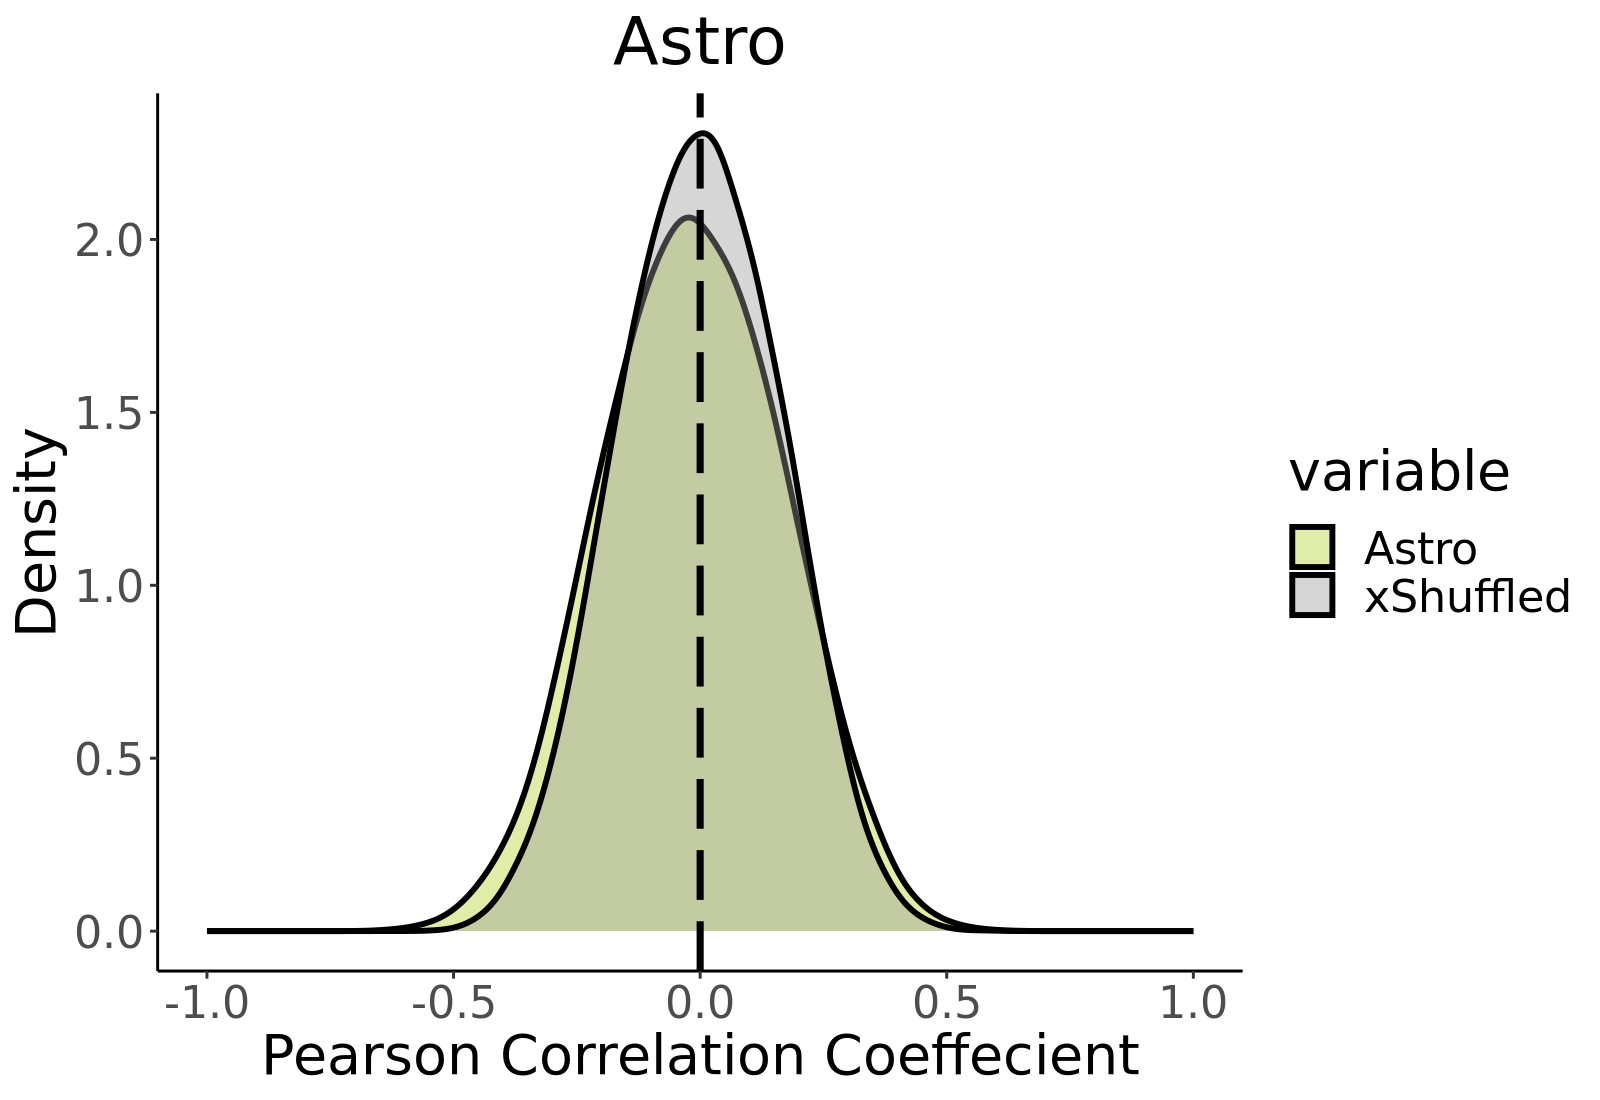

In [13]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 200)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [14]:
output= foreach(i=1:nrow(ratio)) %dopar% {
pval = cor.test(as.numeric(ratio[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [15]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(ratio)

In [16]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$pval < 0.01 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$pval < 0.01 & comb$cor < 0] <- "Down"

In [17]:
write.table(comb, file = paste0(celltype, '_dmr_mc_ratio_pearson.tsv'), sep = '\t')

In [18]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [19]:
write.table(comb, file = paste0(celltype, '_dmr_mc_ratio_pearson_pval_0.01.tsv'), sep = '\t')

In [20]:
comb$genes <- rownames(comb)
ratio$genes <- rownames(ratio)

In [21]:
comb <- join(comb, ratio, by = "genes")
comb[,1:7] <- NULL

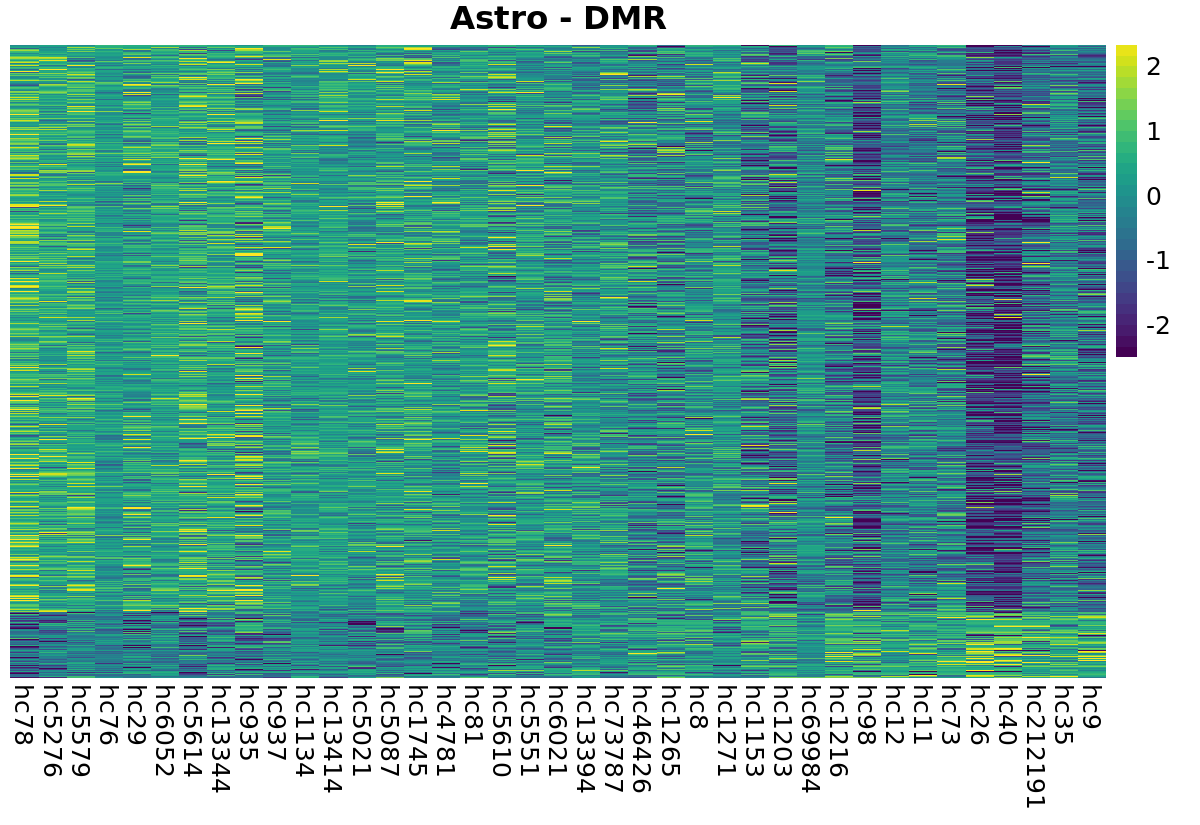

In [22]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 150)
pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-2.5, 2.5, by = 0.166667), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - DMR"))

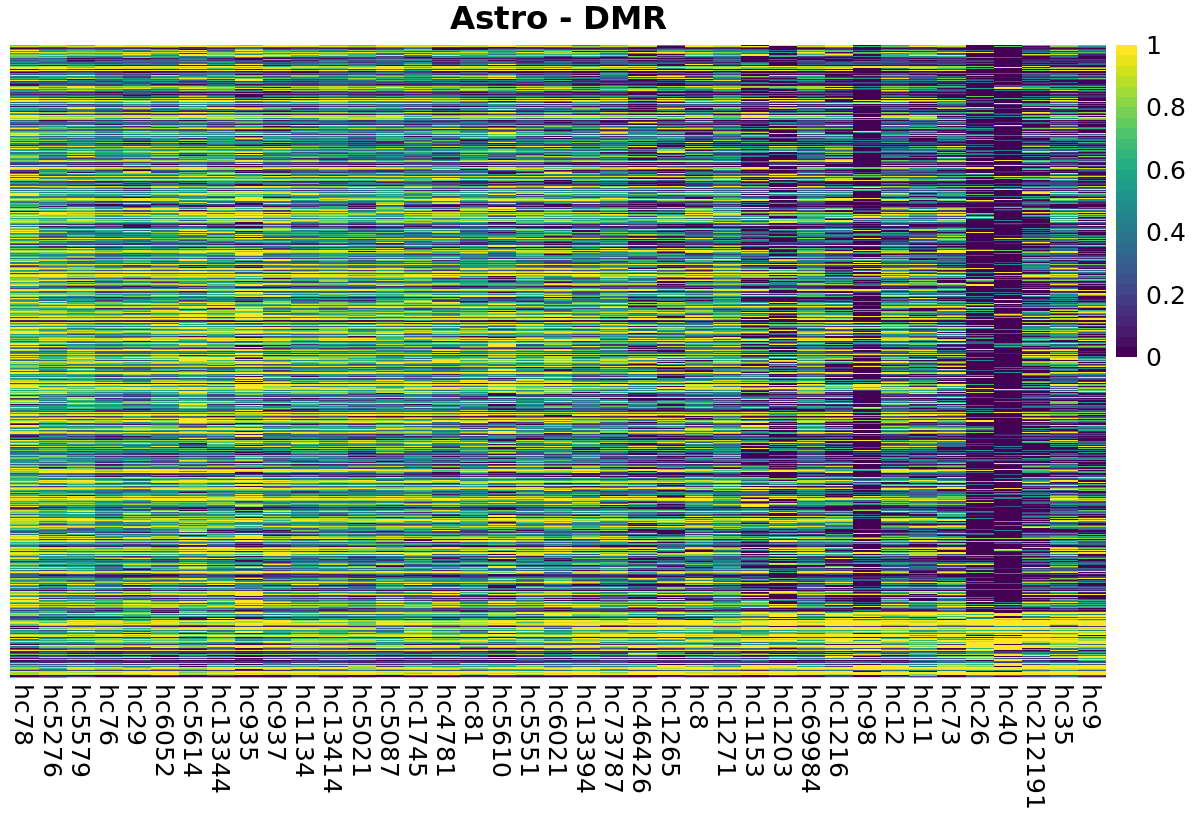

In [23]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 150)
pheatmap(mat=comb, scale = 'none', color = viridis(30), breaks = seq(0, 1, by = 1/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - DMR"))

In [24]:
dim(comb)

[1] 2327   39

In [25]:
celltype <- sprintf(cells[2])
ratio <- read.csv(paste0('mc_ratio/', celltype, '_mc_ratio_donor_dmr_filtered.csv'), header=T, row.names=1)

In [26]:
colnames(ratio) <- gsub('pb|PB|ms|m|M|hs|k|s', 'hc', colnames(ratio))

In [27]:
desired_order <- c('hc78','hc5276','hc5579','hc76','hc29','hc6052','hc5614','hc13344','hc935','hc937','hc1134','hc13414','hc5021','hc5087','hc1745','hc4781','hc81','hc5610','hc5551','hc6021','hc13394','hc73787','hc46426','hc1265','hc8','hc1271','hc1153','hc1203','hc69984','hc1216','hc98','hc12','hc11','hc73','hc19','hc26','hc40','hc212191','hc35','hc9')

filtered_cols <- intersect(desired_order, colnames(ratio))

# Arrange the filtered column names in the order of desired_order
desired_cols <- desired_order[match(filtered_cols, desired_order)]

ratio <- ratio[, desired_cols]

In [28]:
age1 <- age[age$V1 %in% colnames(ratio),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(ratio)), ]
age_mat <- as.data.frame(age_mat)

In [29]:
# calculate pearson correlation 
output= foreach(i=1:nrow(ratio)) %dopar% {
pcc = cor.test(as.numeric(ratio[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)
ratio[is.na(ratio)] <- 0

In [30]:
# calculate shuffled spearman correlation
cpm_shuf <- randomizeMatrix(ratio, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [31]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [32]:
comb <- rbind(pcc, pcc_shuf)

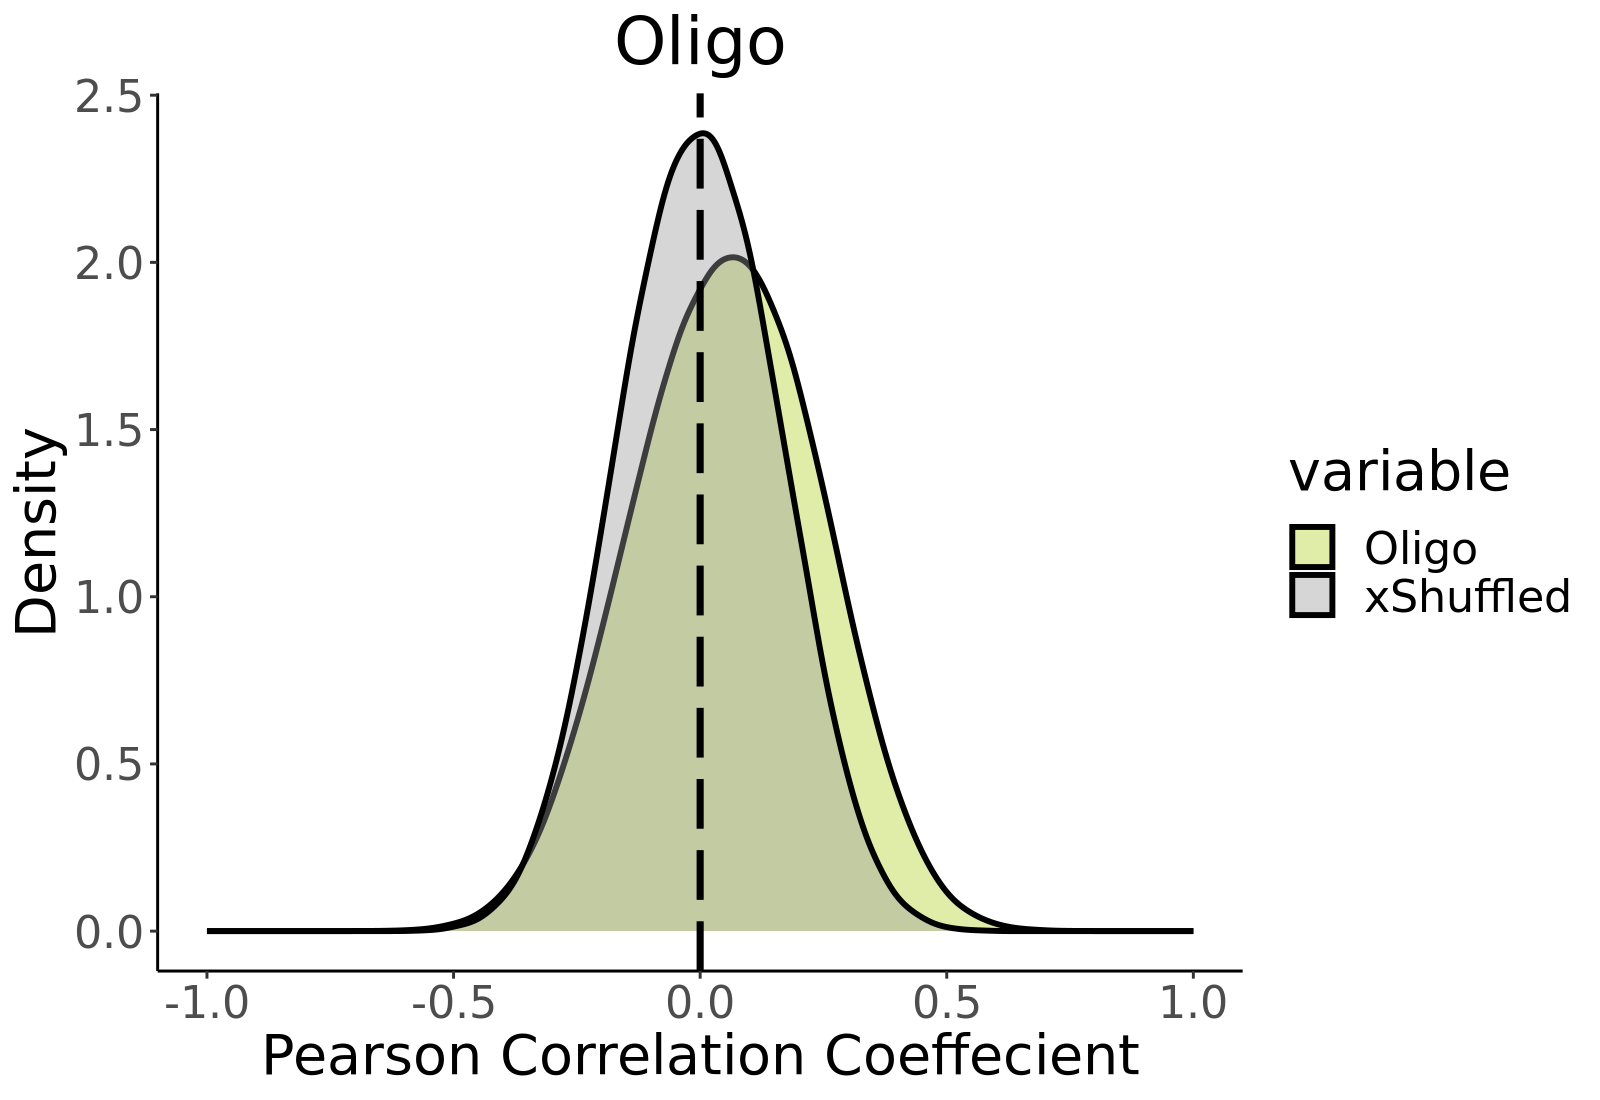

In [33]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 200)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [34]:
output= foreach(i=1:nrow(ratio)) %dopar% {
pval = cor.test(as.numeric(ratio[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [35]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(ratio)

In [36]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$pval < 0.01 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$pval < 0.01 & comb$cor < 0] <- "Down"

In [37]:
write.table(comb, file = paste0(celltype, '_dmr_mc_ratio_pearson.tsv'), sep = '\t')

In [38]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [39]:
write.table(comb, file = paste0(celltype, '_dmr_mc_ratio_pearson_pval_0.01.tsv'), sep = '\t')

In [40]:
comb$genes <- rownames(comb)
ratio$genes <- rownames(ratio)

In [41]:
comb <- join(comb, ratio, by = "genes")
comb[,1:7] <- NULL

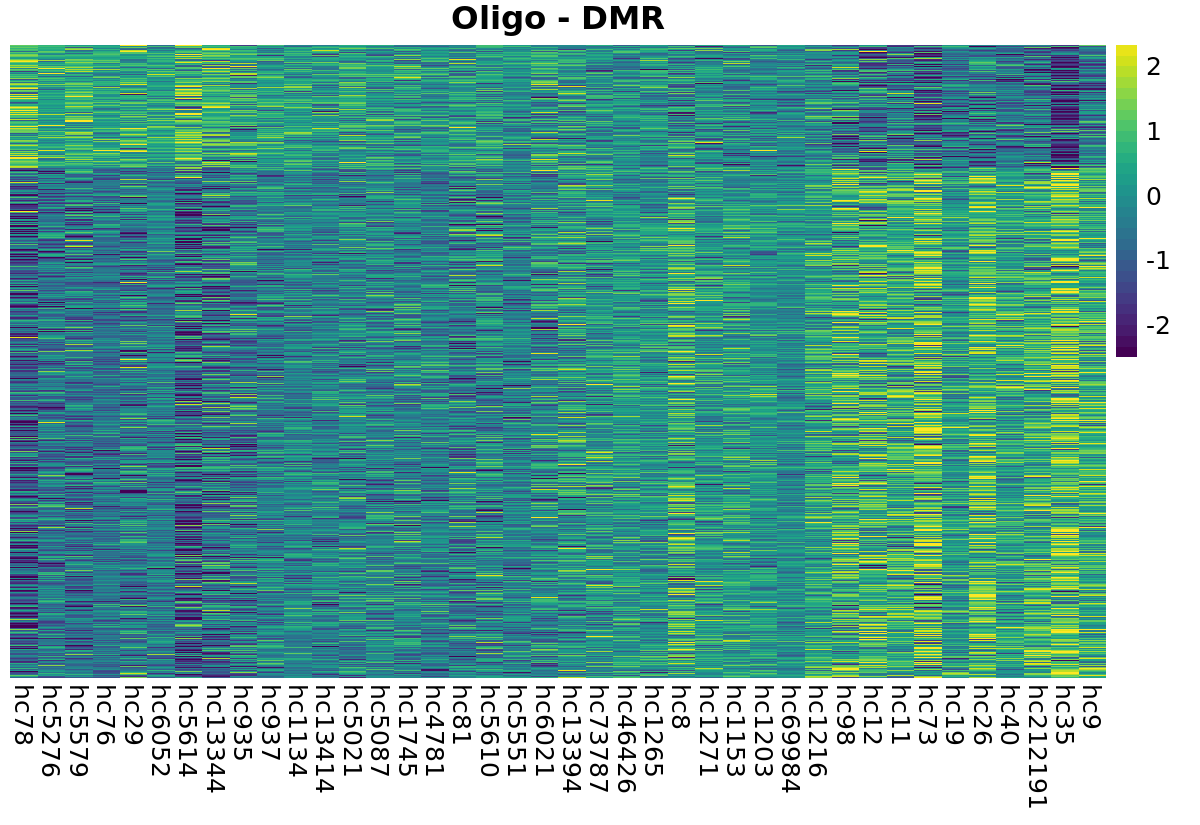

In [42]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 150)
pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-2.5, 2.5, by = 0.166667), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - DMR"))

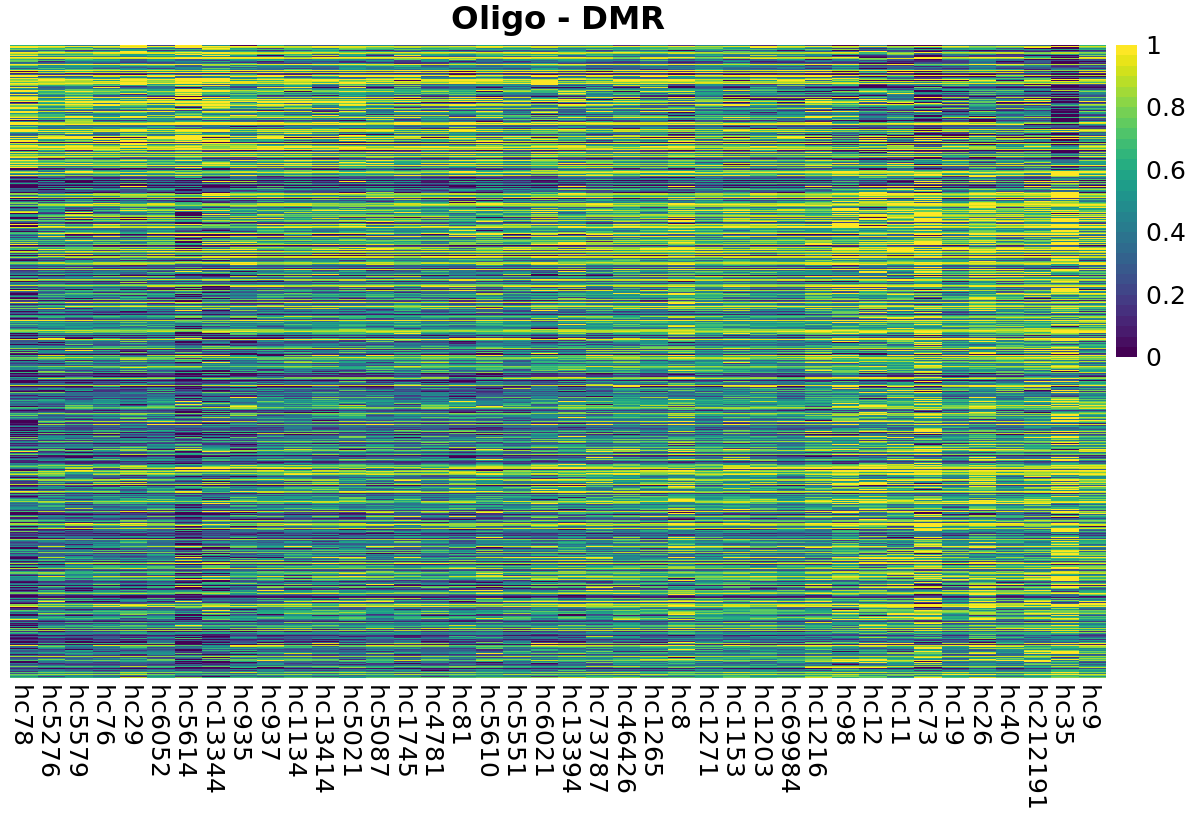

In [43]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 150)
pheatmap(mat=comb, scale = 'none', color = viridis(30), breaks = seq(0, 1, by = 1/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - DMR"))

In [44]:
dim(comb)

[1] 20714    40

In [45]:
celltype <- sprintf(cells[3])
ratio <- read.csv(paste0('mc_ratio/', celltype, '_mc_ratio_donor_dmr_filtered.csv'), header=T, row.names=1)

In [46]:
colnames(ratio) <- gsub('pb|PB|ms|m|M|hs|k|s', 'hc', colnames(ratio))

In [47]:
desired_order <- c('hc78','hc5276','hc5579','hc76','hc29','hc6052','hc5614','hc13344','hc935','hc937','hc1134','hc13414','hc5021','hc5087','hc1745','hc4781','hc81','hc5610','hc5551','hc6021','hc13394','hc73787','hc46426','hc1265','hc8','hc1271','hc1153','hc1203','hc69984','hc1216','hc98','hc12','hc11','hc73','hc19','hc26','hc40','hc212191','hc35','hc9')

filtered_cols <- intersect(desired_order, colnames(ratio))

# Arrange the filtered column names in the order of desired_order
desired_cols <- desired_order[match(filtered_cols, desired_order)]

ratio <- ratio[, desired_cols]

In [48]:
age1 <- age[age$V1 %in% colnames(ratio),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(ratio)), ]
age_mat <- as.data.frame(age_mat)

In [49]:
# calculate pearson correlation 
output= foreach(i=1:nrow(ratio)) %dopar% {
pcc = cor.test(as.numeric(ratio[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)
ratio[is.na(ratio)] <- 0

In [50]:
# calculate shuffled spearman correlation
cpm_shuf <- randomizeMatrix(ratio, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [51]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [52]:
comb <- rbind(pcc, pcc_shuf)

Warning message:
“Removed 1 rows containing non-finite values (`stat_density()`).”


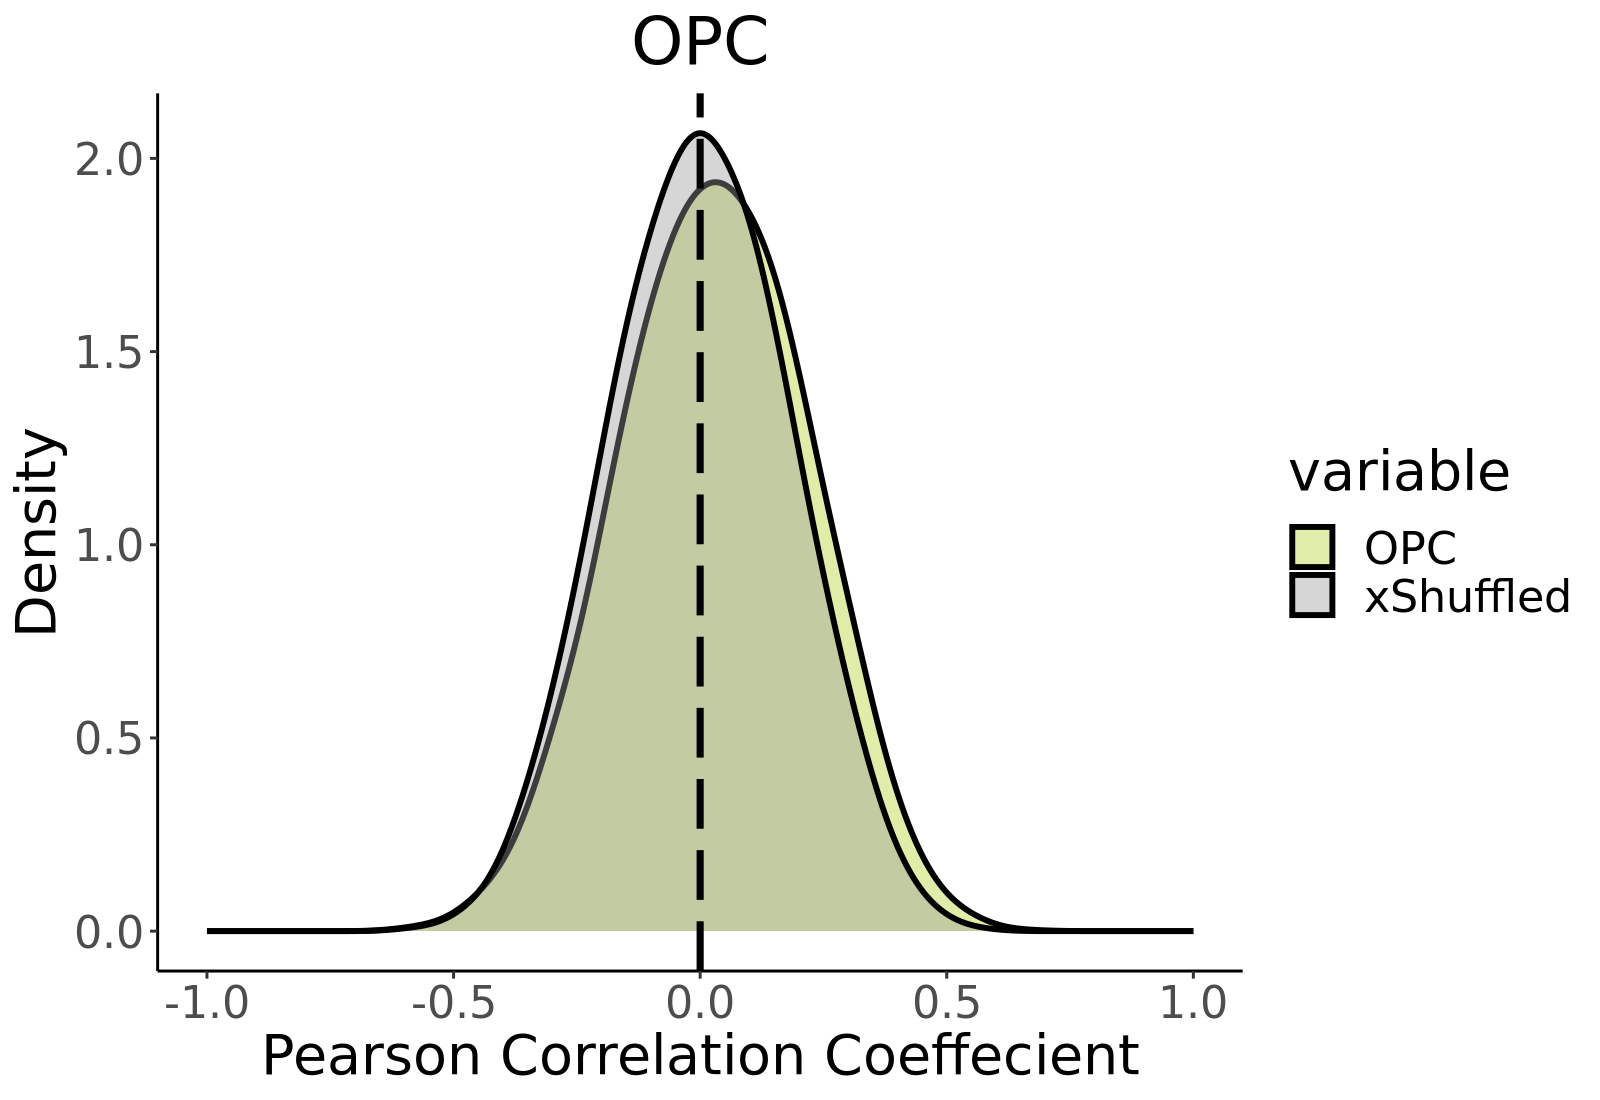

In [53]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 200)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [54]:
output= foreach(i=1:nrow(ratio)) %dopar% {
pval = cor.test(as.numeric(ratio[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [55]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(ratio)

In [56]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$pval < 0.01 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$pval < 0.01 & comb$cor < 0] <- "Down"

In [57]:
write.table(comb, file = paste0(celltype, '_dmr_mc_ratio_pearson.tsv'), sep = '\t')

In [58]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [59]:
write.table(comb, file = paste0(celltype, '_dmr_mc_ratio_pearson_pval_0.01.tsv'), sep = '\t')

In [60]:
comb$genes <- rownames(comb)
ratio$genes <- rownames(ratio)

In [61]:
comb <- join(comb, ratio, by = "genes")
comb[,1:7] <- NULL

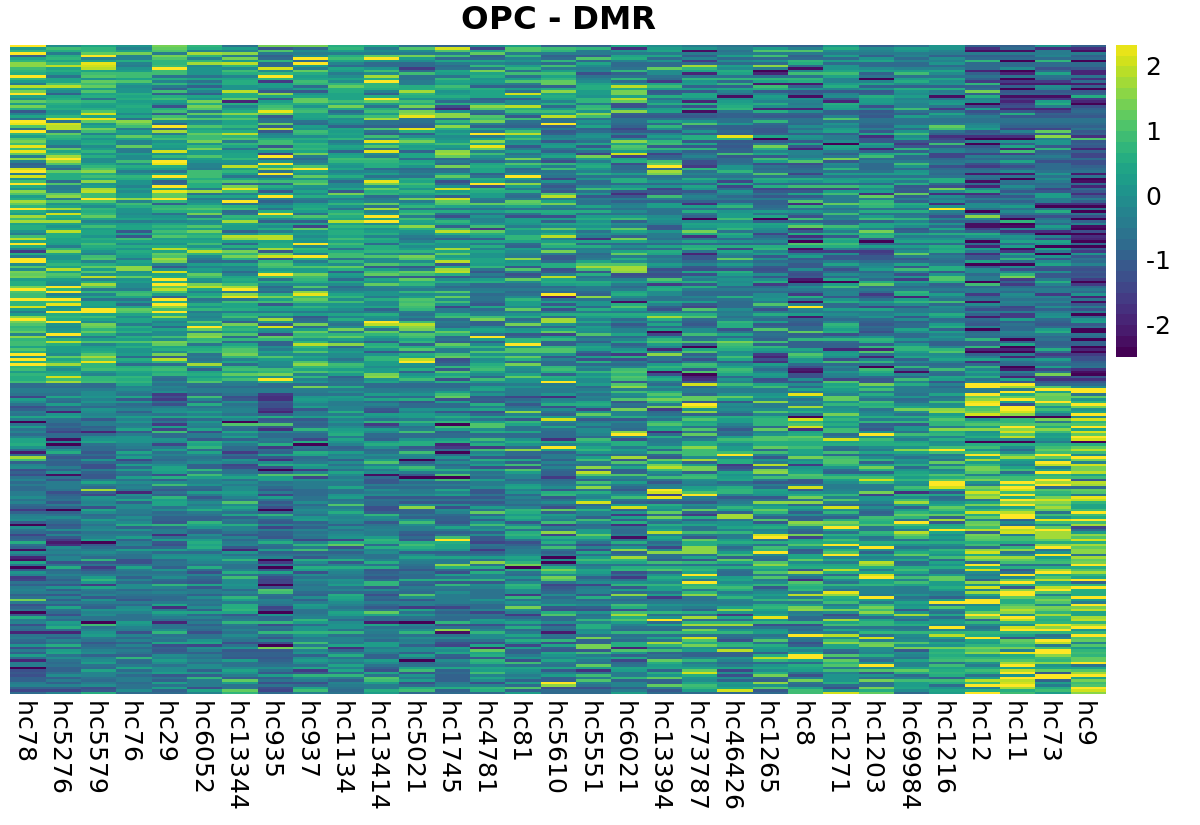

In [62]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 150)
pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-2.5, 2.5, by = 0.166667), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - DMR"))

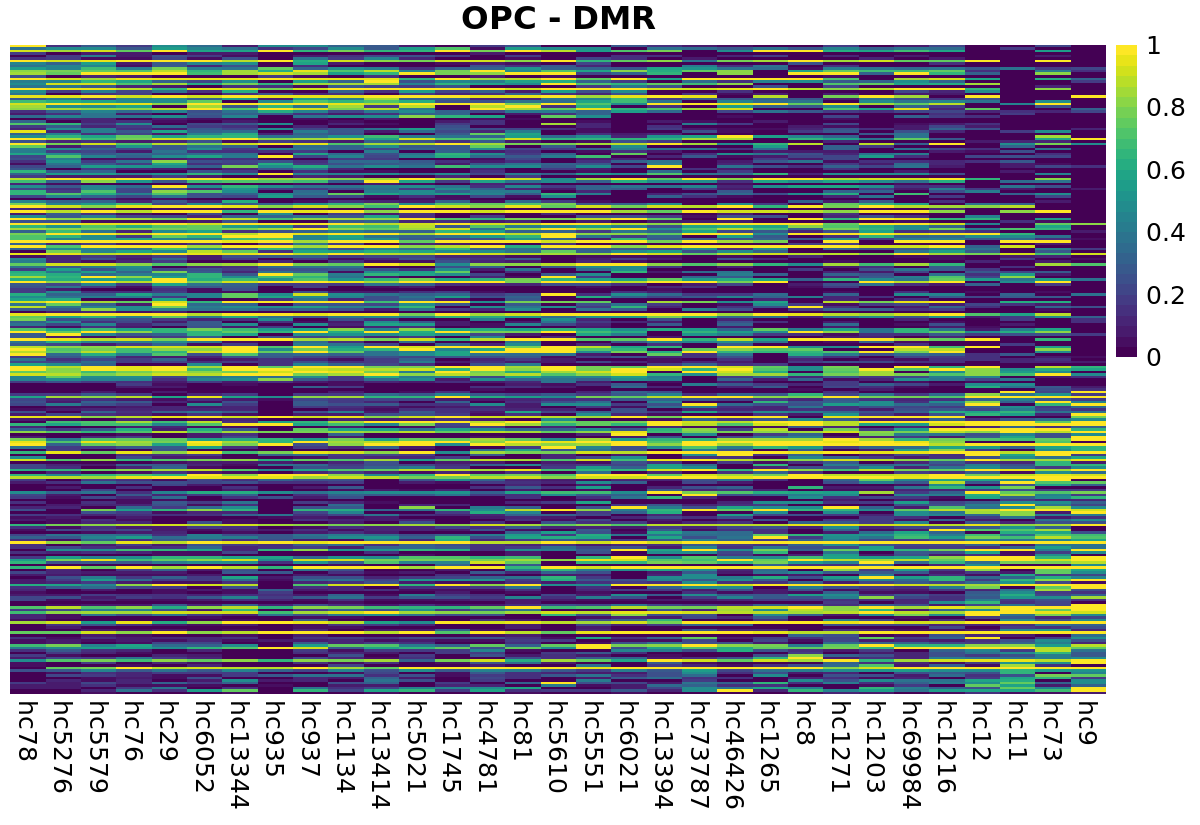

In [63]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 150)
pheatmap(mat=comb, scale = 'none', color = viridis(30), breaks = seq(0, 1, by = 1/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - DMR"))

In [64]:
dim(comb)

[1] 259  31

In [22]:
celltype <- sprintf(cells[4])
ratio <- read.csv(paste0('mc_ratio/', celltype, '_mc_ratio_donor_dmr_filtered.csv'), header=T, row.names=1)

In [23]:
colnames(ratio) <- gsub('pb|PB|ms|m|M|hs|k|s', 'hc', colnames(ratio))

In [24]:
desired_order <- c('hc78','hc5276','hc5579','hc76','hc29','hc6052','hc5614','hc13344','hc935','hc937','hc1134','hc13414','hc5021','hc5087','hc1745','hc4781','hc81','hc5610','hc5551','hc6021','hc13394','hc73787','hc46426','hc1265','hc8','hc1271','hc1153','hc1203','hc69984','hc1216','hc98','hc12','hc11','hc73','hc19','hc26','hc40','hc212191','hc35','hc9')

filtered_cols <- intersect(desired_order, colnames(ratio))

# Arrange the filtered column names in the order of desired_order
desired_cols <- desired_order[match(filtered_cols, desired_order)]

ratio <- ratio[, desired_cols]

In [25]:
age1 <- age[age$V1 %in% colnames(ratio),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(ratio)), ]
age_mat <- as.data.frame(age_mat)

In [26]:
# calculate pearson correlation 
output= foreach(i=1:nrow(ratio)) %dopar% {
pcc = cor.test(as.numeric(ratio[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)
ratio[is.na(ratio)] <- 0

In [27]:
# calculate shuffled spearman correlation
cpm_shuf <- randomizeMatrix(ratio, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [28]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [29]:
comb <- rbind(pcc, pcc_shuf)

Warning message:
“Removed 2 rows containing non-finite values (`stat_density()`).”


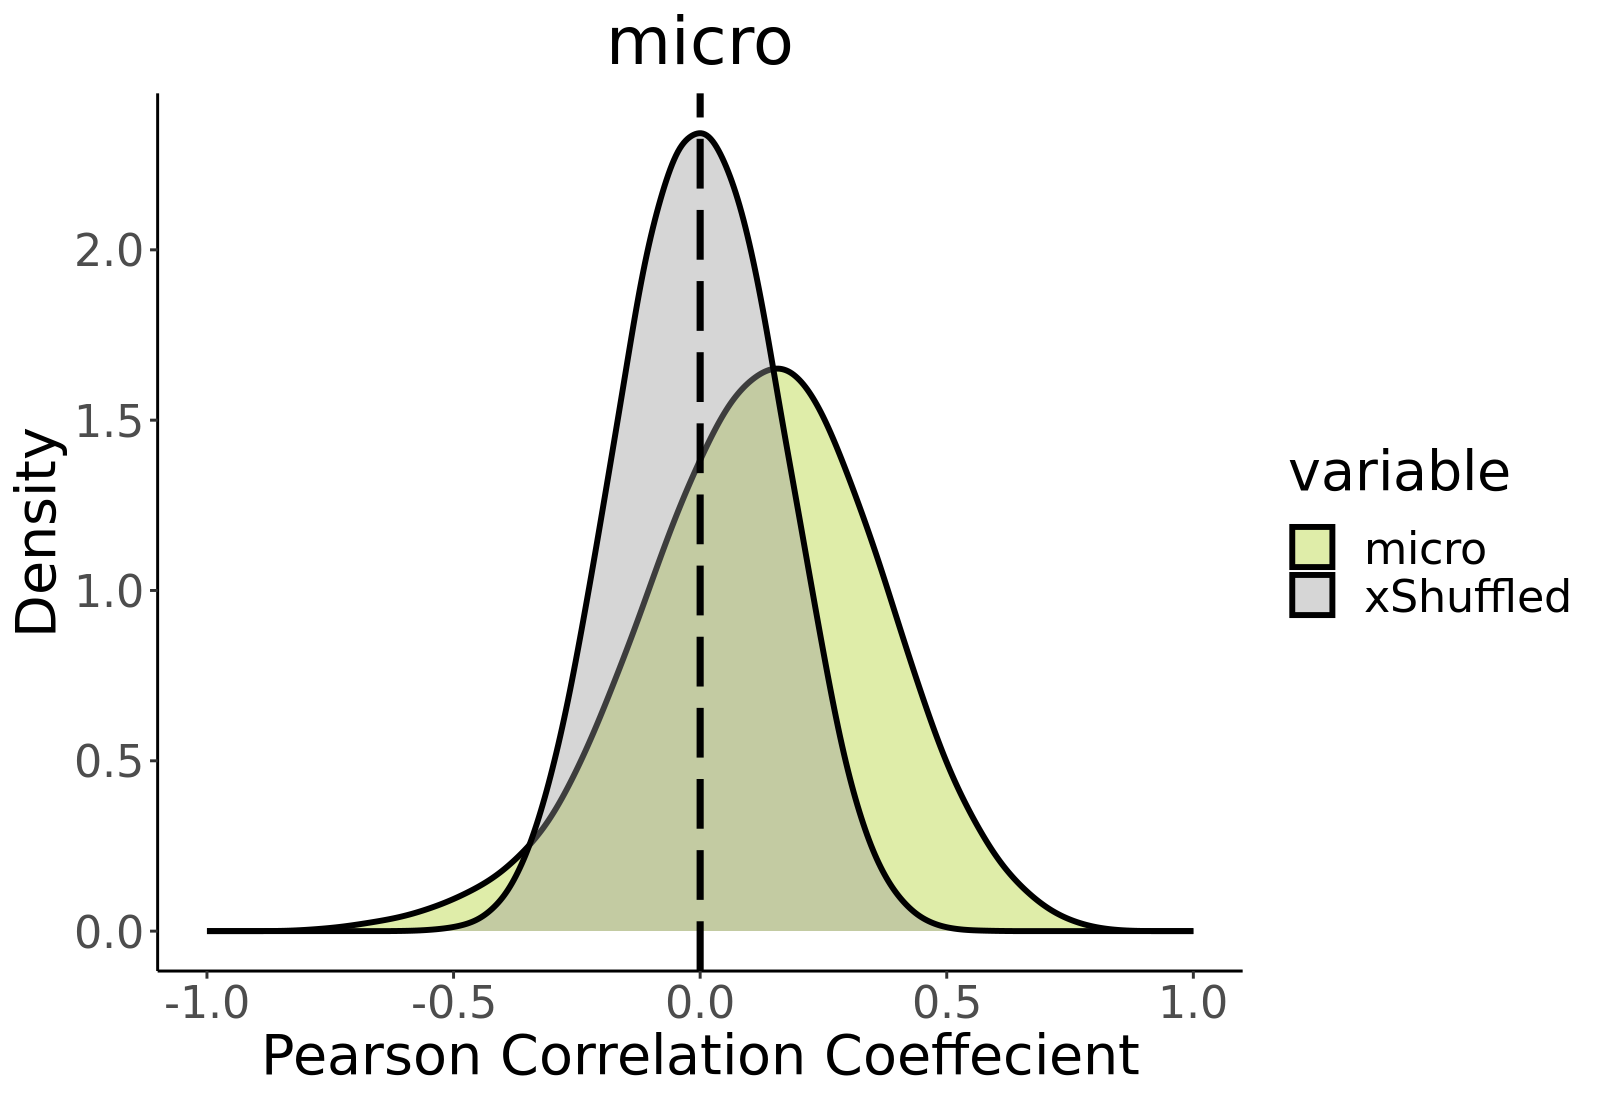

In [30]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 200)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [31]:
output= foreach(i=1:nrow(ratio)) %dopar% {
pval = cor.test(as.numeric(ratio[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [32]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(ratio)

In [33]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$pval < 0.1 & comb$cor < 0] <- "Down"

In [34]:
#write.table(comb, file = paste0(celltype, '_dmr_mc_ratio_pearson.tsv'), sep = '\t')

In [35]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [36]:
#write.table(comb, file = paste0(celltype, '_dmr_mc_ratio_pearson_pval_0.01.tsv'), sep = '\t')

In [37]:
comb$genes <- rownames(comb)
ratio$genes <- rownames(ratio)

In [38]:
comb <- join(comb, ratio, by = "genes")
write.table(comb, file = 'Microglia_mC_up_down_age_cor_dmrs.tsv', sep = '\t', row.names=F)
#comb[,1:7] <- NULL

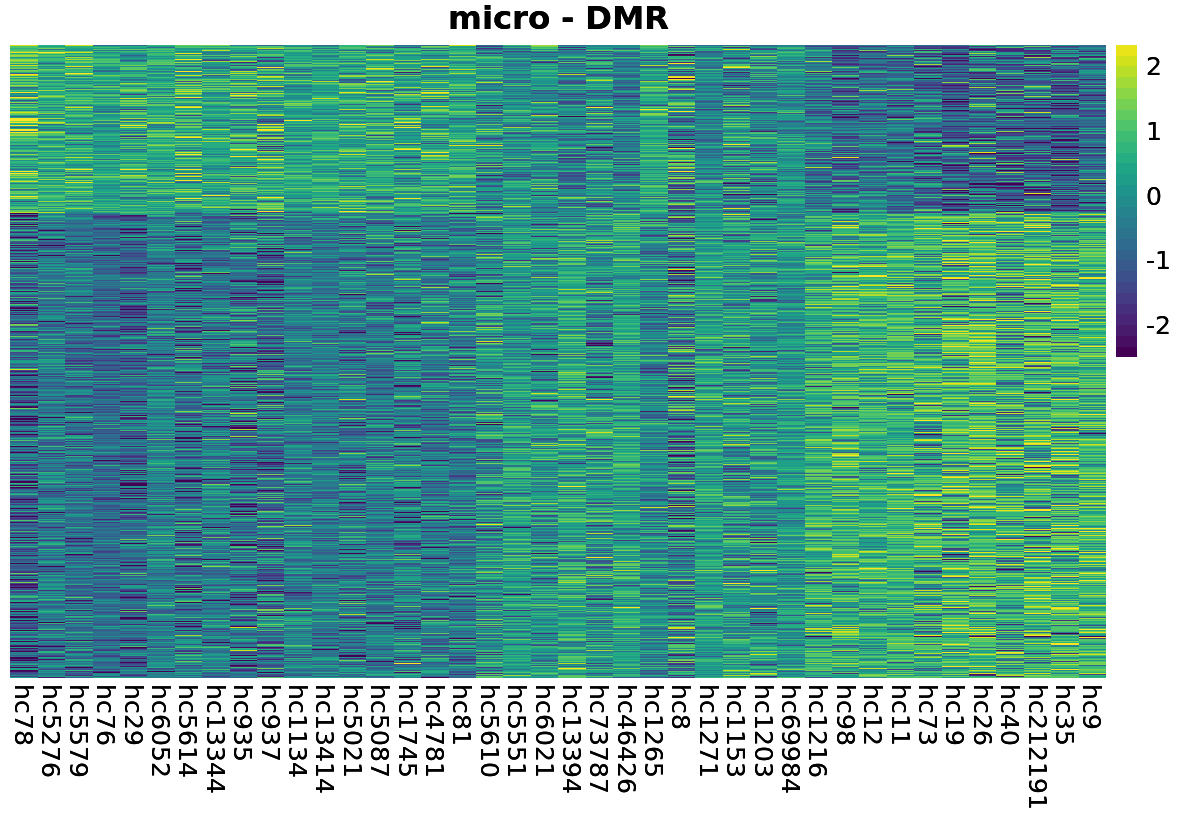

In [36]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 150)
deg1 <- pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-2, 2.5, by = 0.166667), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - DMR"))

deg1
#ggsave("../../ggsave/microglia_dmr_correlation_hetamap.pdf", plot=deg1, font='Helvetica', device="pdf", width=8, height=5.5)

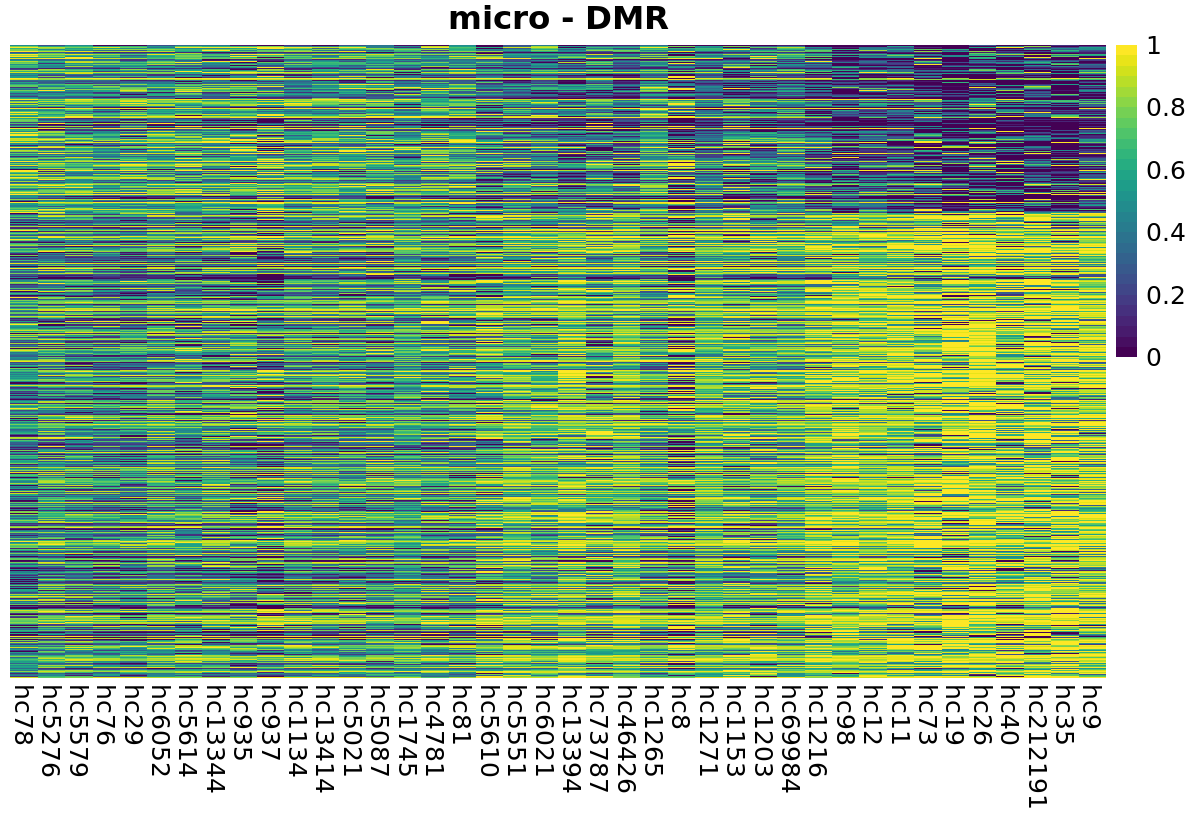

In [34]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 150)
pheatmap(mat=comb, scale = 'none', color = viridis(30), breaks = seq(0, 1, by = 1/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - DMR"))

In [84]:
dim(comb)

[1] 14986    40

In [85]:
celltype <- sprintf(cells[5])
ratio <- read.csv(paste0('mc_ratio/', celltype, '_mc_ratio_donor_dmr_filtered.csv'), header=T, row.names=1)

In [86]:
colnames(ratio) <- gsub('pb|PB|ms|m|M|hs|k|s', 'hc', colnames(ratio))

In [87]:
desired_order <- c('hc78','hc5276','hc5579','hc76','hc29','hc6052','hc5614','hc13344','hc935','hc937','hc1134','hc13414','hc5021','hc5087','hc1745','hc4781','hc81','hc5610','hc5551','hc6021','hc13394','hc73787','hc46426','hc1265','hc8','hc1271','hc1153','hc1203','hc69984','hc1216','hc98','hc12','hc11','hc73','hc19','hc26','hc40','hc212191','hc35','hc9')

filtered_cols <- intersect(desired_order, colnames(ratio))

# Arrange the filtered column names in the order of desired_order
desired_cols <- desired_order[match(filtered_cols, desired_order)]

ratio <- ratio[, desired_cols]

In [88]:
age1 <- age[age$V1 %in% colnames(ratio),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(ratio)), ]
age_mat <- as.data.frame(age_mat)

In [89]:
# calculate pearson correlation 
output= foreach(i=1:nrow(ratio)) %dopar% {
pcc = cor.test(as.numeric(ratio[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)
ratio[is.na(ratio)] <- 0

In [90]:
# calculate shuffled spearman correlation
cpm_shuf <- randomizeMatrix(ratio, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [91]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [92]:
comb <- rbind(pcc, pcc_shuf)

Warning message:
“Removed 86 rows containing non-finite values (`stat_density()`).”


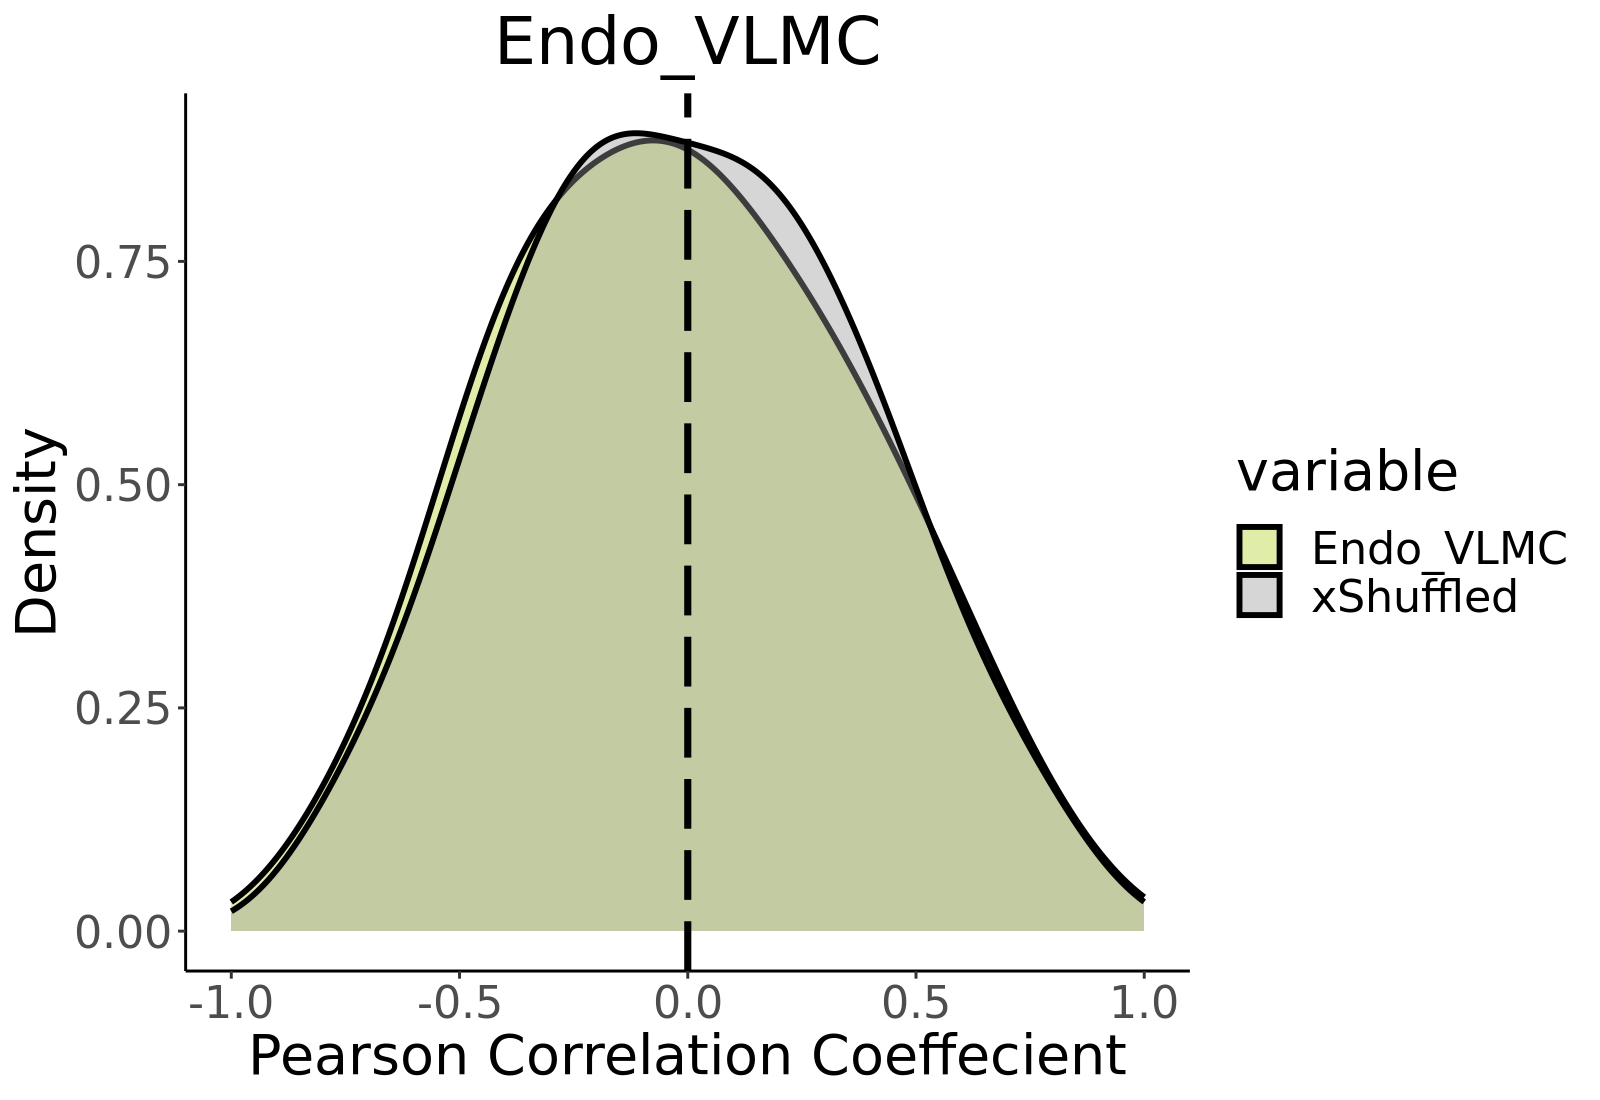

In [93]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 200)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [94]:
output= foreach(i=1:nrow(ratio)) %dopar% {
pval = cor.test(as.numeric(ratio[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [95]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(ratio)

In [96]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$pval < 0.01 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$pval < 0.01 & comb$cor < 0] <- "Down"

In [97]:
write.table(comb, file = paste0(celltype, '_dmr_mc_ratio_pearson.tsv'), sep = '\t')

In [98]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [99]:
write.table(comb, file = paste0(celltype, '_dmr_mc_ratio_pearson_pval_0.01.tsv'), sep = '\t')

In [100]:
comb$genes <- rownames(comb)
ratio$genes <- rownames(ratio)

In [101]:
comb <- join(comb, ratio, by = "genes")
comb[,1:7] <- NULL

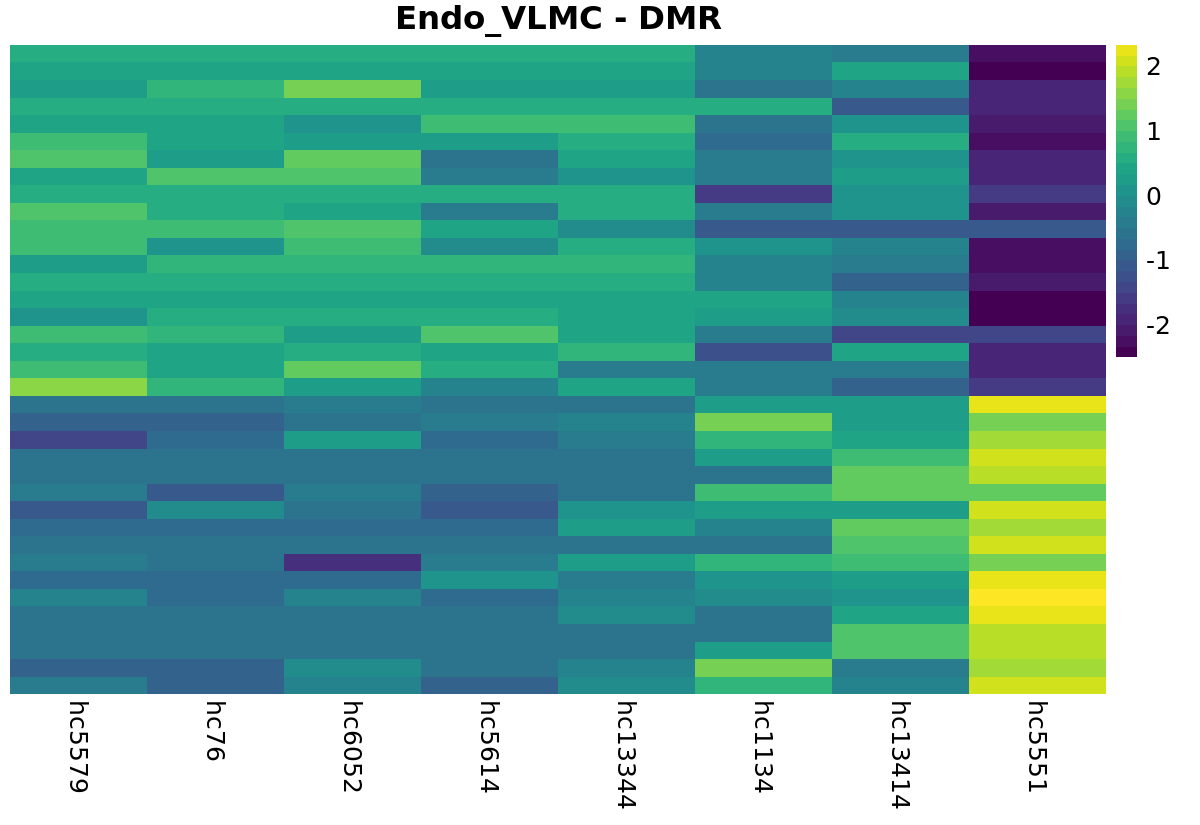

In [102]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 150)
pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-2.5, 2.5, by = 0.166667), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - DMR"))

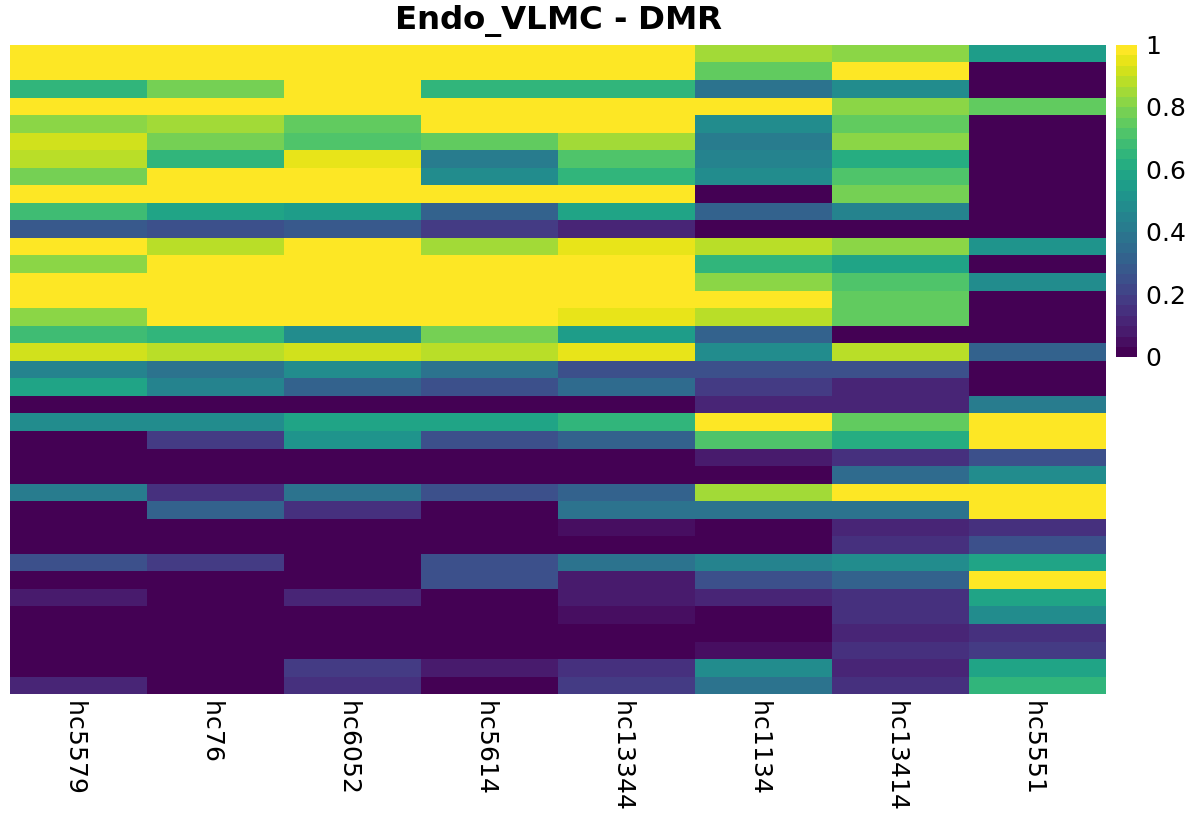

In [103]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 150)
pheatmap(mat=comb, scale = 'none', color = viridis(30), breaks = seq(0, 1, by = 1/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - DMR"))

In [104]:
dim(comb)

[1] 37  8

In [105]:
celltype <- sprintf(cells[6])
ratio <- read.csv(paste0('mc_ratio/', celltype, '_mc_ratio_donor_dmr_filtered.csv'), header=T, row.names=1)

In [106]:
colnames(ratio) <- gsub('pb|PB|ms|m|M|hs|k|s', 'hc', colnames(ratio))

In [107]:
desired_order <- c('hc78','hc5276','hc5579','hc76','hc29','hc6052','hc5614','hc13344','hc935','hc937','hc1134','hc13414','hc5021','hc5087','hc1745','hc4781','hc81','hc5610','hc5551','hc6021','hc13394','hc73787','hc46426','hc1265','hc8','hc1271','hc1153','hc1203','hc69984','hc1216','hc98','hc12','hc11','hc73','hc19','hc26','hc40','hc212191','hc35','hc9')

filtered_cols <- intersect(desired_order, colnames(ratio))

# Arrange the filtered column names in the order of desired_order
desired_cols <- desired_order[match(filtered_cols, desired_order)]

ratio <- ratio[, desired_cols]

In [108]:
age1 <- age[age$V1 %in% colnames(ratio),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(ratio)), ]
age_mat <- as.data.frame(age_mat)

In [109]:
# calculate pearson correlation 
output= foreach(i=1:nrow(ratio)) %dopar% {
pcc = cor.test(as.numeric(ratio[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)
ratio[is.na(ratio)] <- 0

In [110]:
# calculate shuffled spearman correlation
cpm_shuf <- randomizeMatrix(ratio, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [111]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [112]:
comb <- rbind(pcc, pcc_shuf)

Warning message:
“Removed 2 rows containing non-finite values (`stat_density()`).”


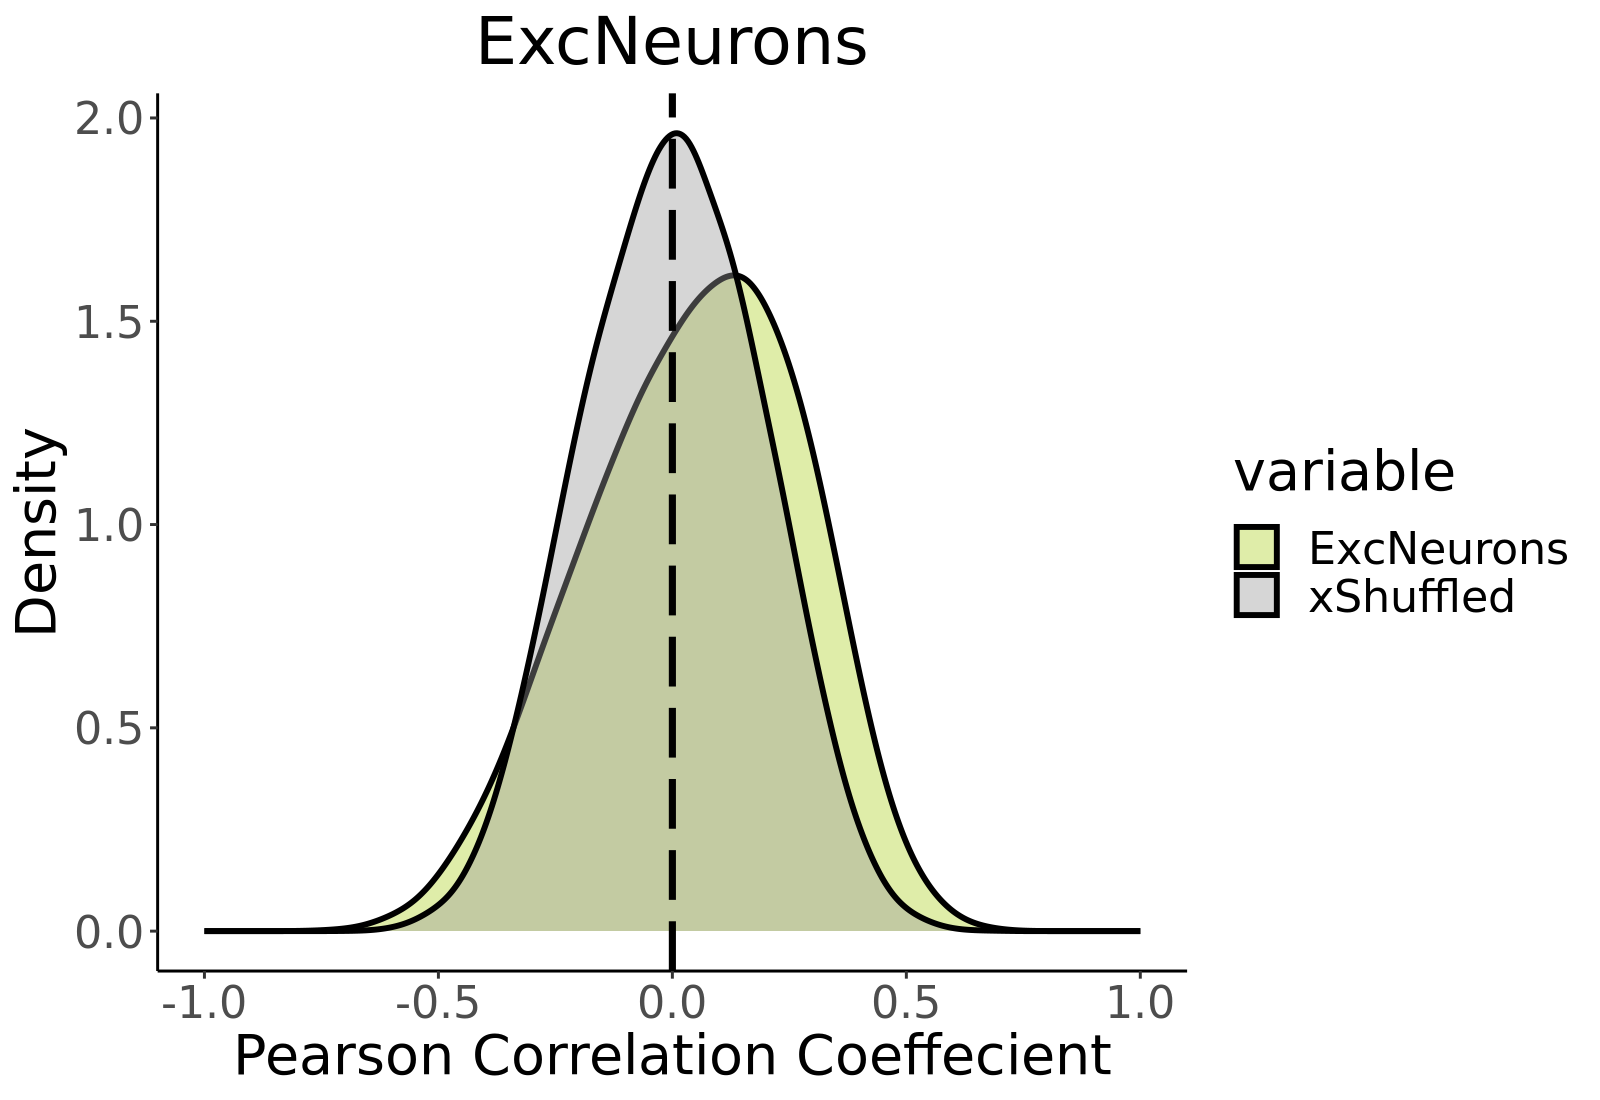

In [113]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 200)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [114]:
output= foreach(i=1:nrow(ratio)) %dopar% {
pval = cor.test(as.numeric(ratio[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [115]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(ratio)

In [116]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$pval < 0.01 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$pval < 0.01 & comb$cor < 0] <- "Down"

In [117]:
write.table(comb, file = paste0(celltype, '_dmr_mc_ratio_pearson.tsv'), sep = '\t')

In [118]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [119]:
write.table(comb, file = paste0(celltype, '_dmr_mc_ratio_pearson_pval_0.01.tsv'), sep = '\t')

In [120]:
comb$genes <- rownames(comb)
ratio$genes <- rownames(ratio)

In [121]:
comb <- join(comb, ratio, by = "genes")
comb[,1:7] <- NULL

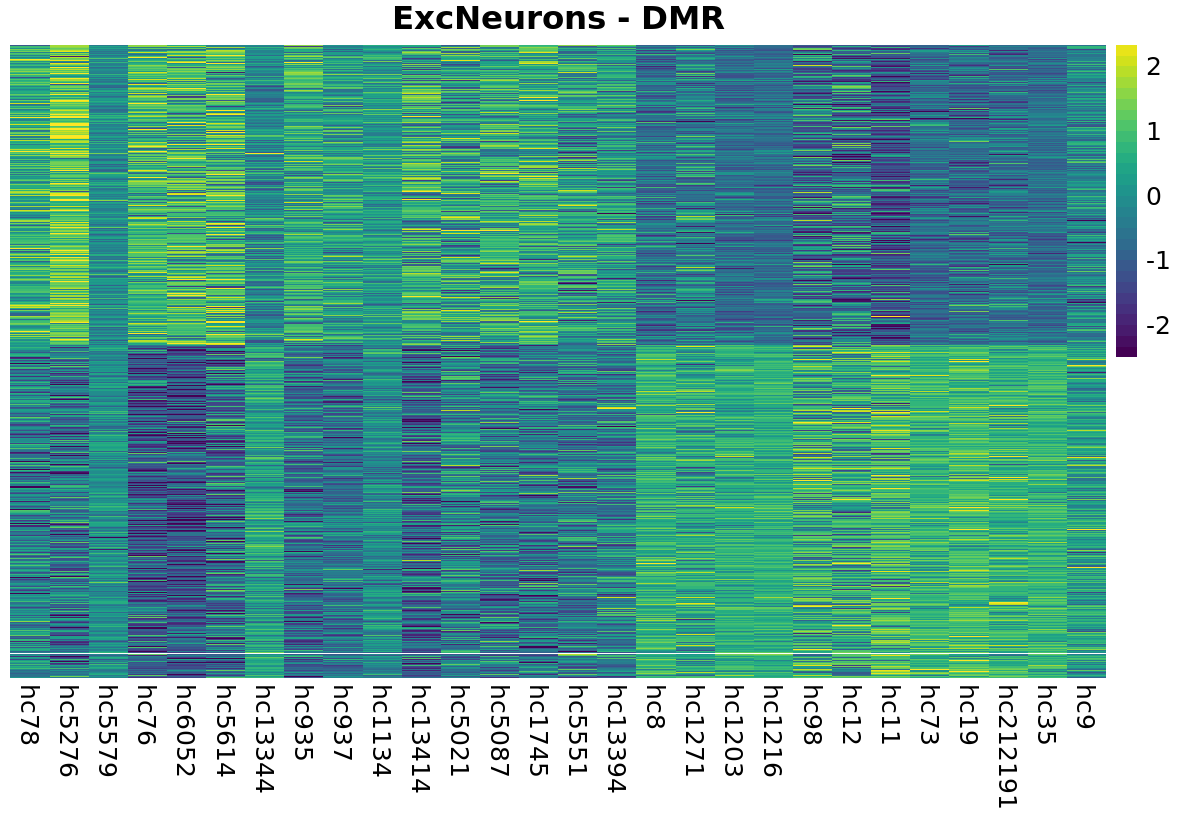

In [122]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 150)
pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-2.5, 2.5, by = 0.166667), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - DMR"))

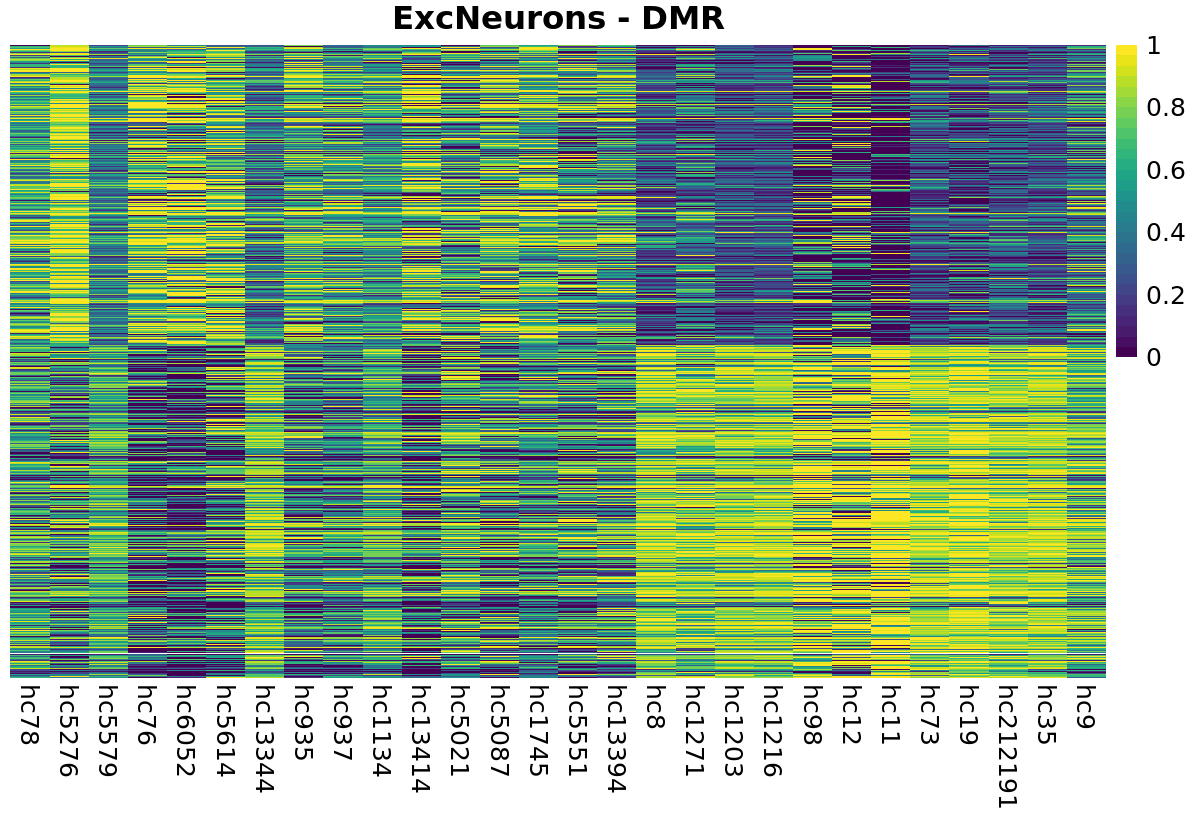

In [123]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 150)
pheatmap(mat=comb, scale = 'none', color = viridis(30), breaks = seq(0, 1, by = 1/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - DMR"))

In [124]:
dim(comb)

[1] 1181   28

In [125]:
celltype <- sprintf(cells[7])
ratio <- read.csv(paste0('mc_ratio/', celltype, '_mc_ratio_donor_dmr_filtered.csv'), header=T, row.names=1)

In [126]:
colnames(ratio) <- gsub('pb|PB|ms|m|M|hs|k|s', 'hc', colnames(ratio))

In [127]:
desired_order <- c('hc78','hc5276','hc5579','hc76','hc29','hc6052','hc5614','hc13344','hc935','hc937','hc1134','hc13414','hc5021','hc5087','hc1745','hc4781','hc81','hc5610','hc5551','hc6021','hc13394','hc73787','hc46426','hc1265','hc8','hc1271','hc1153','hc1203','hc69984','hc1216','hc98','hc12','hc11','hc73','hc19','hc26','hc40','hc212191','hc35','hc9')

filtered_cols <- intersect(desired_order, colnames(ratio))

# Arrange the filtered column names in the order of desired_order
desired_cols <- desired_order[match(filtered_cols, desired_order)]

ratio <- ratio[, desired_cols]

In [128]:
age1 <- age[age$V1 %in% colnames(ratio),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(ratio)), ]
age_mat <- as.data.frame(age_mat)

In [129]:
# calculate pearson correlation 
output= foreach(i=1:nrow(ratio)) %dopar% {
pcc = cor.test(as.numeric(ratio[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)
ratio[is.na(ratio)] <- 0

In [130]:
# calculate shuffled spearman correlation
cpm_shuf <- randomizeMatrix(ratio, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [131]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [132]:
comb <- rbind(pcc, pcc_shuf)

Warning message:
“Removed 4 rows containing non-finite values (`stat_density()`).”


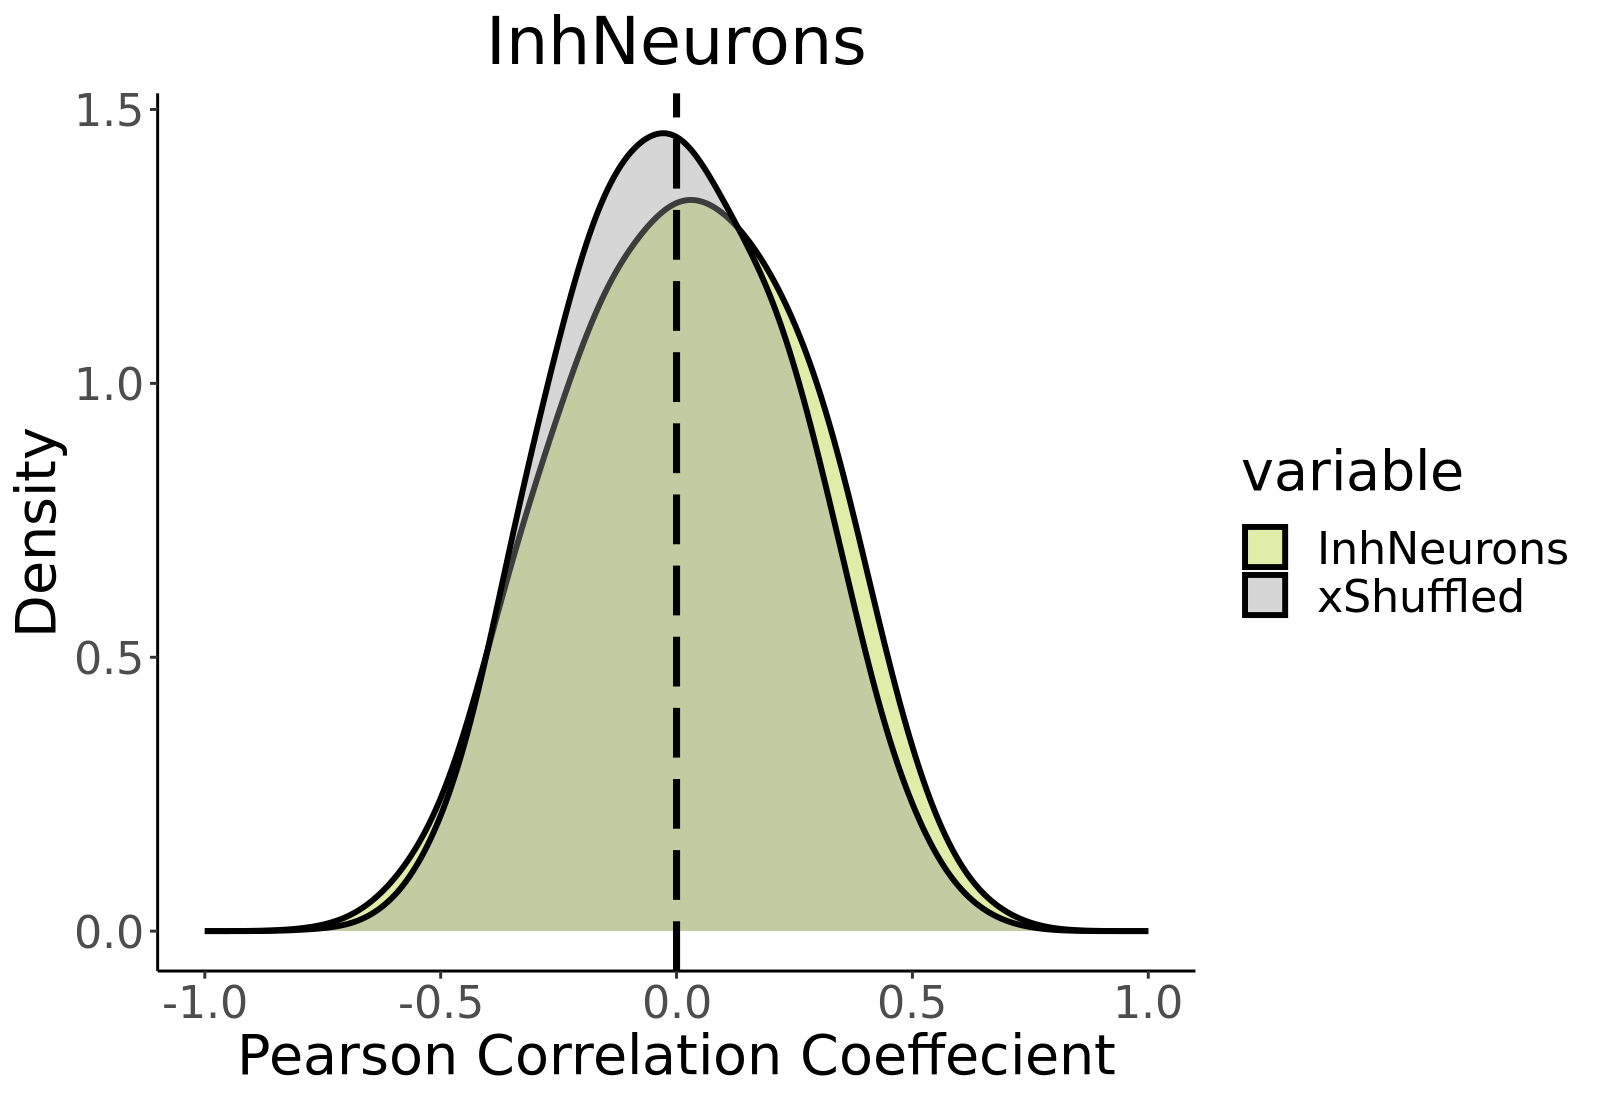

In [133]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 200)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [134]:
output= foreach(i=1:nrow(ratio)) %dopar% {
pval = cor.test(as.numeric(ratio[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [135]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(ratio)

In [136]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$pval < 0.01 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$pval < 0.01 & comb$cor < 0] <- "Down"

In [137]:
write.table(comb, file = paste0(celltype, '_dmr_mc_ratio_pearson.tsv'), sep = '\t')

In [138]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [139]:
write.table(comb, file = paste0(celltype, '_dmr_mc_ratio_pearson_pval_0.01.tsv'), sep = '\t')

In [140]:
comb$genes <- rownames(comb)
ratio$genes <- rownames(ratio)

In [141]:
comb <- join(comb, ratio, by = "genes")
comb[,1:7] <- NULL

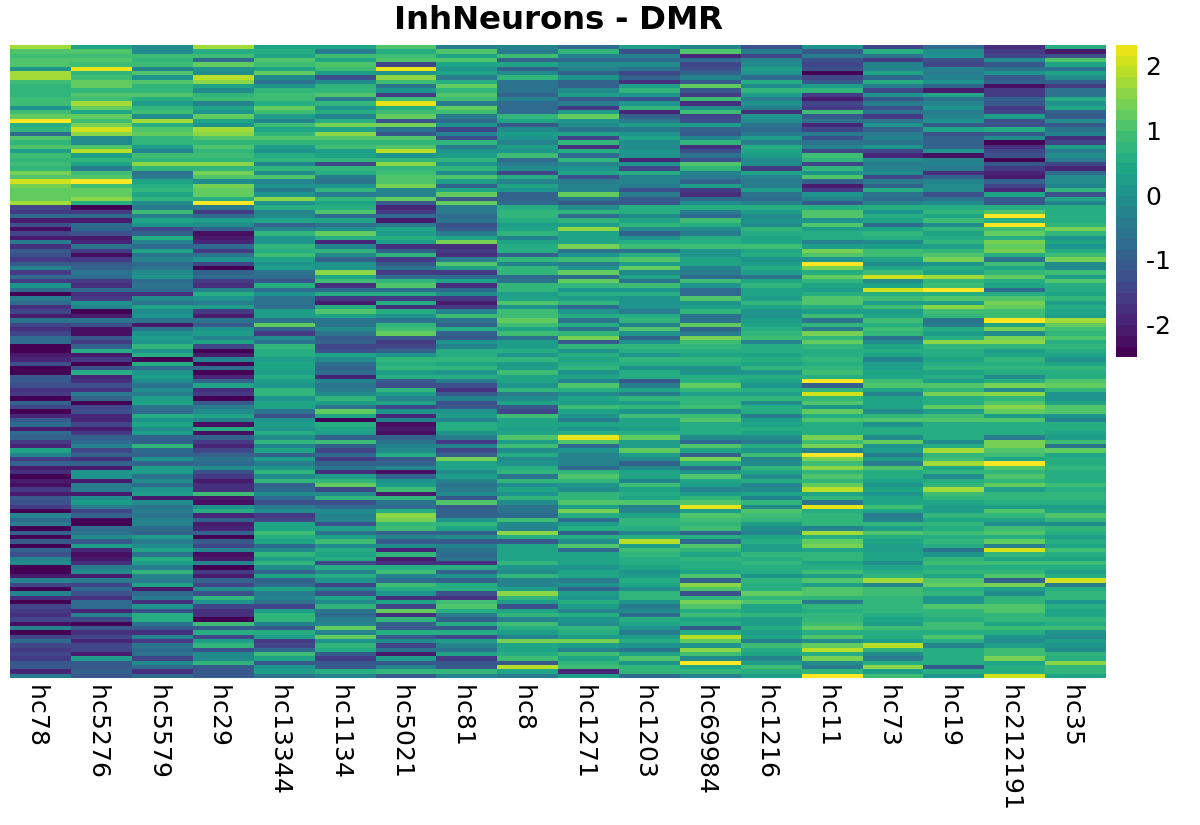

In [142]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 150)
pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-2.5, 2.5, by = 0.166667), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - DMR"))

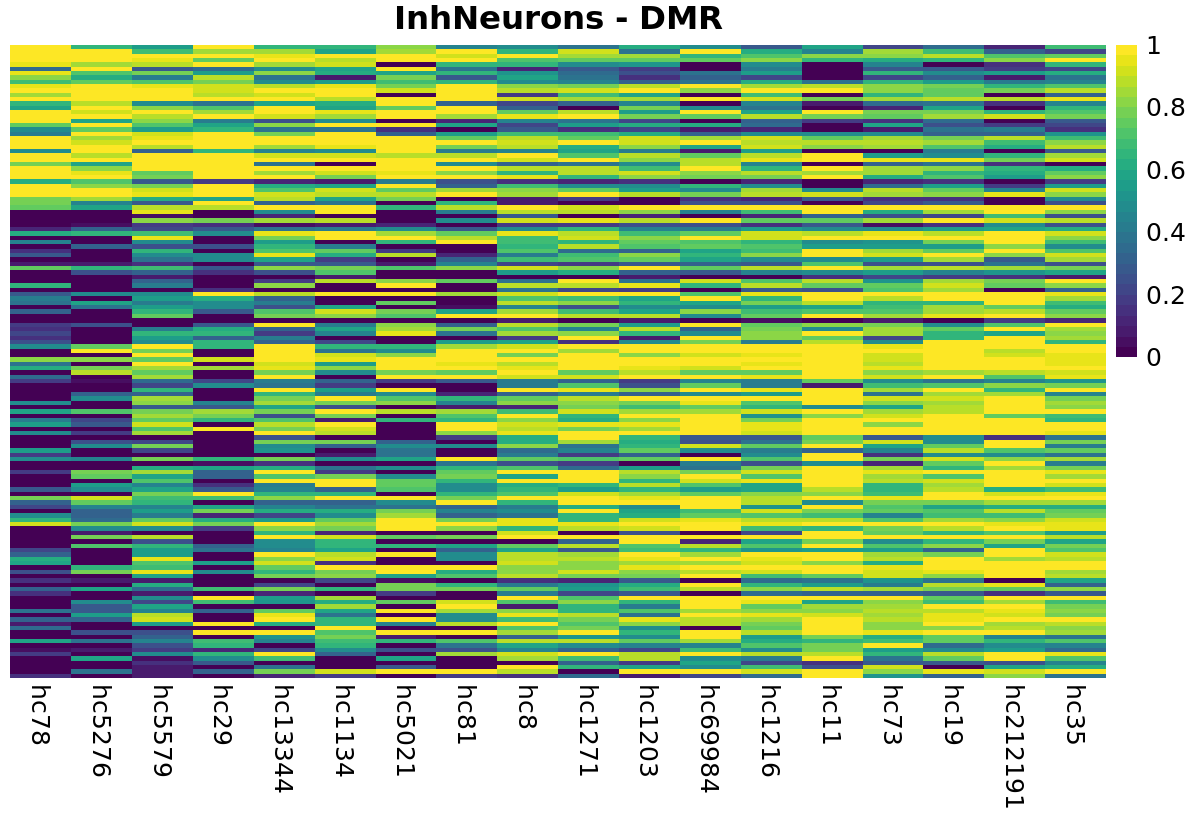

In [143]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 150)
pheatmap(mat=comb, scale = 'none', color = viridis(30), breaks = seq(0, 1, by = 1/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - DMR"))

In [144]:
dim(comb)

[1] 146  18

In [32]:
#hoxa locus microglia

In [33]:
celltype <- sprintf(cells[4])
ratio <- read.csv(paste0('mc_ratio/', celltype, '_mc_ratio_donor_dmr_filtered.csv'), header=T, row.names=1)

In [34]:
colnames(ratio) <- gsub('pb|PB|ms|m|M|hs|k|s', 'hc', colnames(ratio))

In [35]:
desired_order <- c('hc78','hc5276','hc5579','hc76','hc29','hc6052','hc5614','hc13344','hc935','hc937','hc1134','hc13414','hc5021','hc5087','hc1745','hc4781','hc81','hc5610','hc5551','hc6021','hc13394','hc73787','hc46426','hc1265','hc8','hc1271','hc1153','hc1203','hc69984','hc1216','hc98','hc12','hc11','hc73','hc19','hc26','hc40','hc212191','hc35','hc9')

filtered_cols <- intersect(desired_order, colnames(ratio))

# Arrange the filtered column names in the order of desired_order
desired_cols <- desired_order[match(filtered_cols, desired_order)]

ratio <- ratio[, desired_cols]

In [36]:
age1 <- age[age$V1 %in% colnames(ratio),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(ratio)), ]
age_mat <- as.data.frame(age_mat)

In [37]:
# calculate pearson correlation 
output= foreach(i=1:nrow(ratio)) %dopar% {
pcc = cor.test(as.numeric(ratio[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)
ratio[is.na(ratio)] <- 0

In [38]:
# calculate shuffled spearman correlation
cpm_shuf <- randomizeMatrix(ratio, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [39]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [40]:
comb <- rbind(pcc, pcc_shuf)

Warning message:
“Removed 2 rows containing non-finite values (`stat_density()`).”


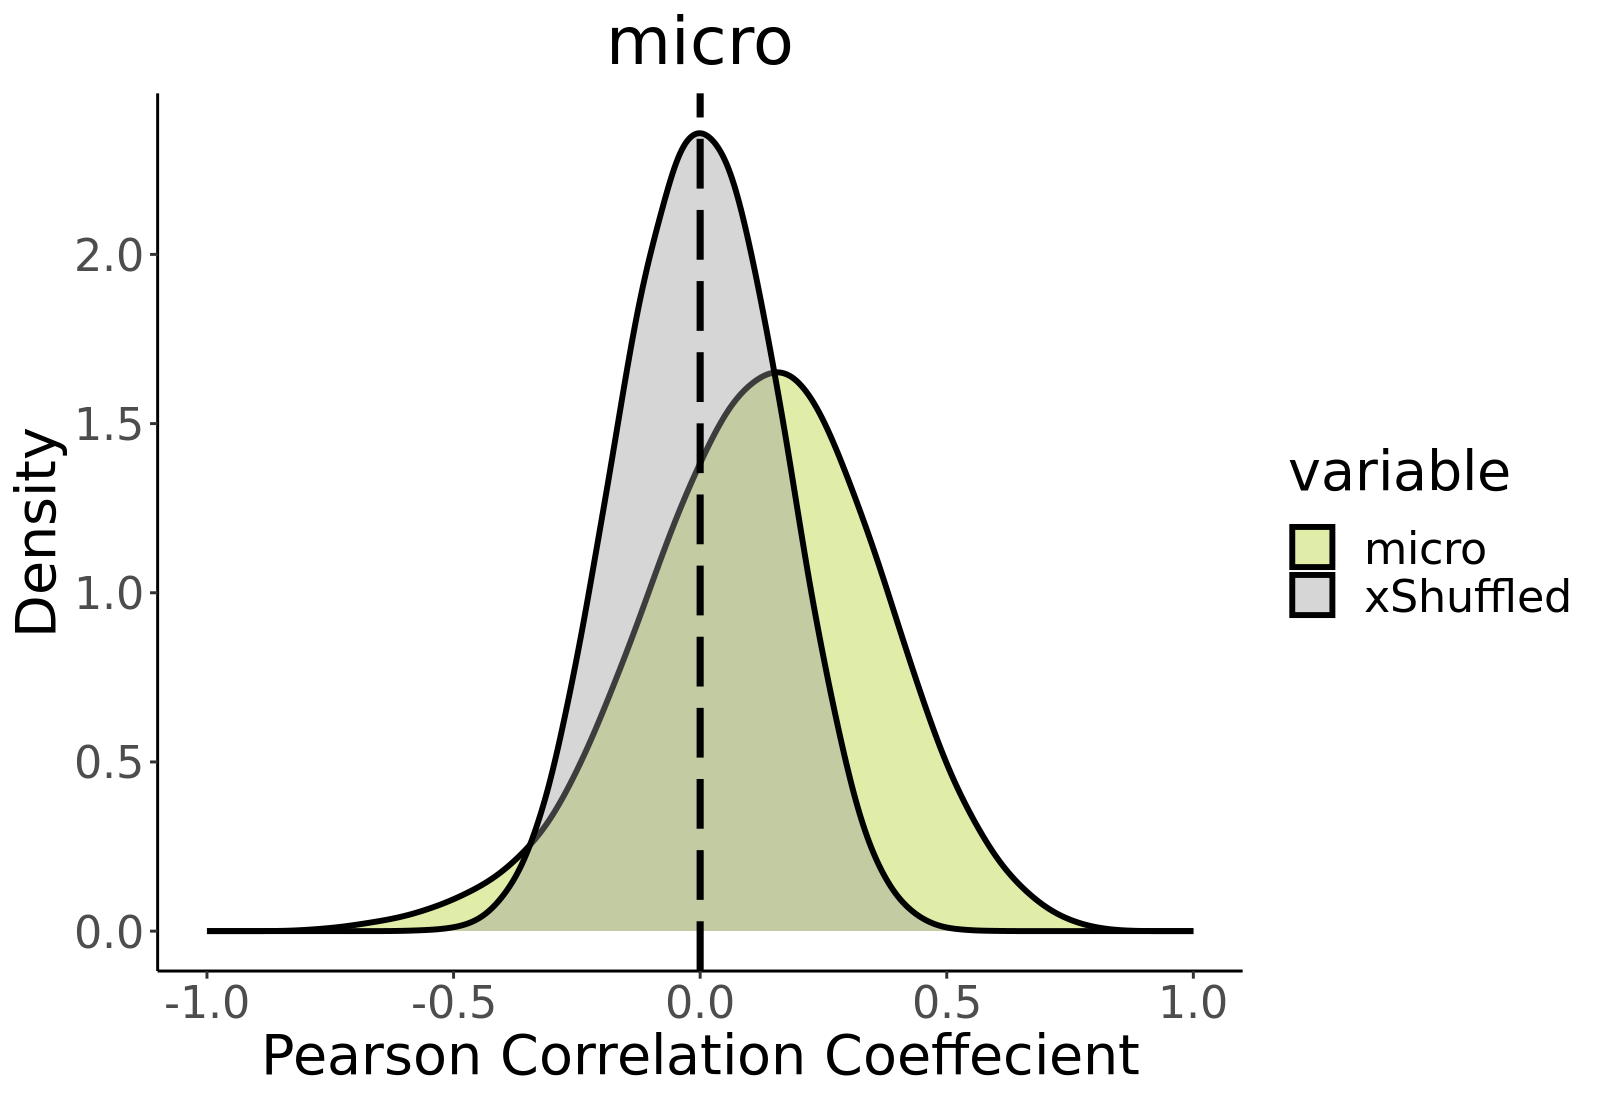

In [41]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 200)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [42]:
output= foreach(i=1:nrow(ratio)) %dopar% {
pval = cor.test(as.numeric(ratio[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [43]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(ratio)

In [44]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$pval < 0.01 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$pval < 0.01 & comb$cor < 0] <- "Down"

In [45]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [46]:
comb$genes <- rownames(comb)
ratio$genes <- rownames(ratio)

In [47]:
hoxa <- read.table('hoxa_locus_up_dmrs_microglia.bed')

In [50]:
ratio$V1 <- row.names(ratio)

In [51]:
comb <- join(hoxa, ratio, by = "V1")
#comb[,1:7] <- NULL

In [55]:
row.names(comb) <- comb$V1

In [57]:
comb$genes <- NULL
comb$V1 <- NULL

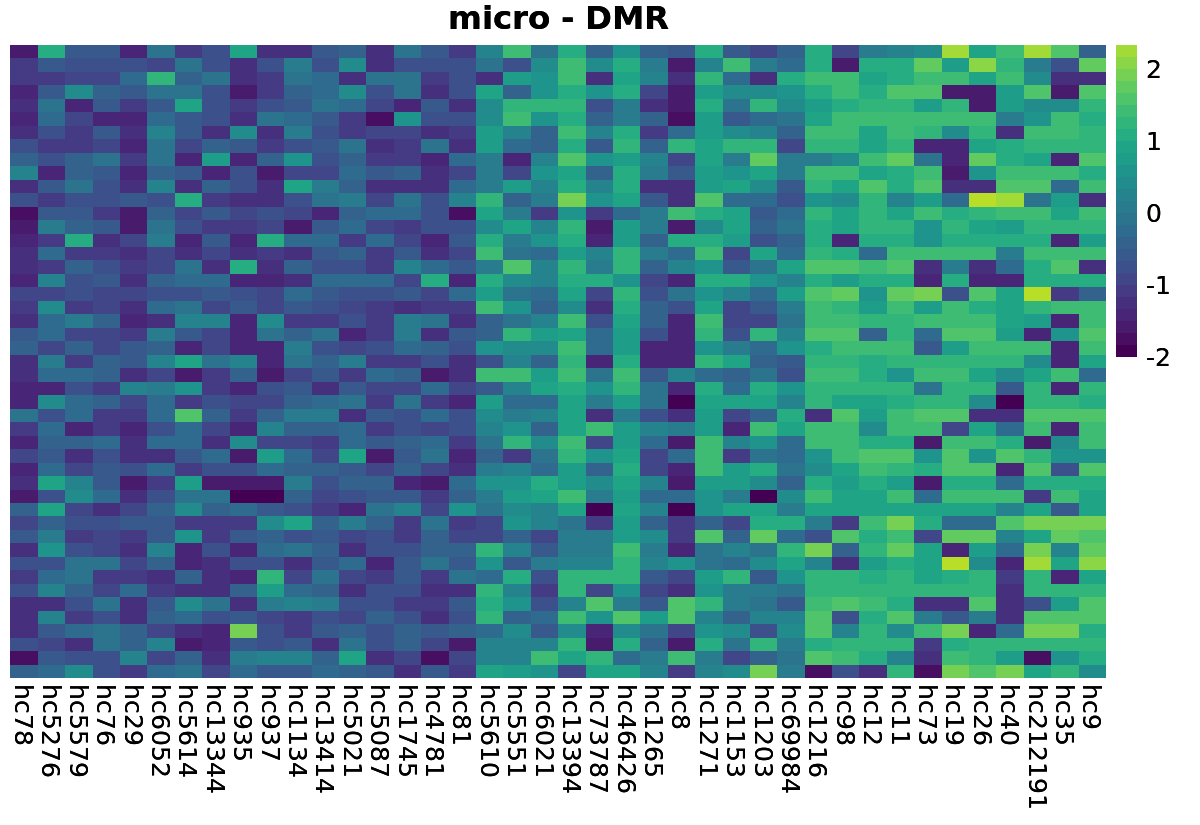

In [59]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 150)
deg1 <- pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-2, 2.5, by = 0.166667), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - DMR"))

deg1
ggsave("../../ggsave/microglia_dmr_up_hoxa_locus_hetamap.pdf", plot=deg1, font='Helvetica', device="pdf", width=8, height=5.5)